# Load libraries

In [1]:
import sys
!{sys.executable} -m pip install pandas numpy matplotlib scikit-learn seaborn umap-learn scipy xgboost shap PyALE


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: pip3 install --upgrade pip


In [2]:
import pandas as pd
pd.set_option('display.max_columns', None)

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colormaps  # Ensure this is imported
import matplotlib.dates as mdates
from matplotlib.gridspec import GridSpec
import seaborn as sns
import math
import json
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import root_mean_squared_error, r2_score
import shap
from PyALE import ale
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.stats import linregress, spearmanr

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Loading the data

In [42]:
chamau_lag = pd.read_csv("../datasets/Chamau_2014-2024_clean_newlag.csv")
chamau_daily = pd.read_csv("../datasets/Chamau_Daily_2014-2024_newlag.csv")
oensingen_1_lag = pd.read_csv("../datasets/Oensingen_2018-19_clean_newlag.csv")
oensingen_1_daily = pd.read_csv("../datasets/Oensingen_Daily_2018-19_newlag.csv")
oensingen_2_lag = pd.read_csv("../datasets/Oensingen_2021-23_clean_newlag.csv")
oensingen_2_daily = pd.read_csv("../datasets/Oensingen_Daily_2021-23_newlag.csv")
aeschi_lag = pd.read_csv("../datasets/Aeschi_2019-20_clean_newlag.csv")
aeschi_daily = pd.read_csv("../datasets/Aeschi_Daily_2019-20_newlag.csv")
forel_lag = pd.read_csv("../datasets/Forel_2024-25_clean_newlag.csv")
forel_daily = pd.read_csv("../datasets/Forel_Daily_2024-25_newlag.csv")
tanikon_lag = pd.read_csv("../datasets/Tanikon_2023-25_clean_newlag.csv")
tanikon_daily = pd.read_csv("../datasets/Tanikon_Daily_2023-25_newlag.csv")

# Experiment 1: Oensingen 2018-19

In [157]:
# FIX TIMESTAMP
oensingen_1_lag['Timestamp'] = pd.to_datetime(oensingen_1_lag['Timestamp'])
oensingen_1_lag = oensingen_1_lag.set_index('Timestamp').sort_index()

oensingen_1_daily['Date'] = pd.to_datetime(oensingen_1_daily['Date'])
oensingen_1_daily = oensingen_1_daily.sort_values('Date')


# PREDICTOR SETS
predictor_sets = {
    "base": [
        "Precipitation", "SolarRadiation", "AirTemp", "VPD",
        "SoilWater_5cm", "SoilWater_15cm", "SoilWater_30cm", "SoilTemp_5cm", "SoilTemp_15cm", "SoilTemp_30cm",
        "NEE", "GPP", "RECO",
        "Mowing", "FertilizerOrganic", "FertilizerMineral", "SoilCultivation"
    ],
    
    "lag": [
        "Precipitation", "SolarRadiation", "AirTemp", "VPD",
        "SoilWater_5cm", "SoilWater_15cm", "SoilWater_30cm",
        "SoilTemp_5cm", "SoilTemp_15cm", "SoilTemp_30cm",
        "NEE", "GPP", "RECO",
        "Precipitation_lag1d", "Precipitation_lag3d", "Precipitation_lag5d", "Precipitation_lag7d",
        "SolarRadiation_lag1d", "SolarRadiation_lag3d", "SolarRadiation_lag5d", "SolarRadiation_lag7d",
        "AirTemp_lag1d", "AirTemp_lag3d", "AirTemp_lag5d", "AirTemp_lag7d",
        "VPD_lag1d", "VPD_lag3d", "VPD_lag5d", "VPD_lag7d",
        "SoilWater_5cm_lag1d", "SoilWater_5cm_lag3d", "SoilWater_5cm_lag5d", "SoilWater_5cm_lag7d",
        "SoilWater_15cm_lag1d", "SoilWater_15cm_lag3d", "SoilWater_15cm_lag5d", "SoilWater_15cm_lag7d",
        "SoilWater_30cm_lag1d", "SoilWater_30cm_lag3d", "SoilWater_30cm_lag5d", "SoilWater_30cm_lag7d",
        "SoilTemp_5cm_lag1d", "SoilTemp_5cm_lag3d", "SoilTemp_5cm_lag5d", "SoilTemp_5cm_lag7d",
        "SoilTemp_15cm_lag1d", "SoilTemp_15cm_lag3d", "SoilTemp_15cm_lag5d", "SoilTemp_15cm_lag7d",
        "SoilTemp_30cm_lag1d", "SoilTemp_30cm_lag3d", "SoilTemp_30cm_lag5d", "SoilTemp_30cm_lag7d",
        "NEE_lag1d", "NEE_lag3d", "NEE_lag5d", "NEE_lag7d",
        "GPP_lag1d", "GPP_lag3d", "GPP_lag5d", "GPP_lag7d",
        "RECO_lag1d", "RECO_lag3d", "RECO_lag5d", "RECO_lag7d",
        "Mowing", "FertilizerOrganic", "FertilizerMineral", "SoilCultivation",
        "DaysSince_Mowing", "DaysSince_FertilizerOrganic", "DaysSince_FertilizerMineral",
        "DaysSince_SoilCultivation"
    ],
    
    "main": ["AirTemp", "VPD", "SoilTemp_5cm", "SoilTemp_15cm", "RECO", "SolarRadiation"]
}

# DATASETS
datasets = {
    "Hourly": oensingen_1_lag,
    "Daily": oensingen_1_daily
}

targets = ["N2O_Flux", "N2O_Flux_ln"]

In [158]:
# RUN ALL EXPERIMENTS
results = []

for df_name, df in datasets.items():
    for target in targets:
        for set_name, preds in predictor_sets.items():
            print(f"\n{df_name} | {target} | {set_name}")
            
            try:
                # PREP DATA
                X = df[preds]
                y = df[target]
                mask = X.notna().all(axis=1) & y.notna()
                X, y = X[mask], y[mask]
                
                # OFFSET
                offset = abs(y.min()) + 1e-6
                y = y + offset
                
                # SPLIT
                split = int(len(X) * 0.8)
                X_train, X_test = X.iloc[:split], X.iloc[split:]
                y_train, y_test = y.iloc[:split], y.iloc[split:]
                
                # TRAIN
                model = XGBRegressor(
                    max_depth=6,
                    learning_rate=0.1,
                    n_estimators=300,
                    subsample=0.8,
                    colsample_bytree=0.8,
                    random_state=42,
                    n_jobs=-1
                )
                model.fit(X_train, y_train, verbose=False)
                
                # PREDICT
                y_pred = model.predict(X_test) - offset
                y_test = y_test - offset
                
                # EVALUATE
                r2 = r2_score(y_test, y_pred)
                rho, _ = spearmanr(y_test, y_pred)
                
                results.append({
                    "Dataset": df_name,
                    "Target": target,
                    "Predictors": set_name,
                    "R2": r2,
                    "Spearman": rho
                })
                
                print(f"  R²={r2:.3f}, ρ={rho:.3f}")
                
            except Exception as e:
                print(f"  ERROR: {e}")
                results.append({
                    "Dataset": df_name,
                    "Target": target,
                    "Predictors": set_name,
                    "R2": None,
                    "Spearman": None
                })

# DISPLAY RESULTS
results_df = pd.DataFrame(results)
print("\n" + "="*60)
print("=== Summary Results ===")
print(results_df.round(3))


Hourly | N2O_Flux | base
  R²=-0.131, ρ=0.327

Hourly | N2O_Flux | lag
  R²=-0.274, ρ=0.323

Hourly | N2O_Flux | main
  R²=-0.602, ρ=-0.012

Hourly | N2O_Flux_ln | base
  R²=-0.164, ρ=0.319

Hourly | N2O_Flux_ln | lag
  R²=-0.045, ρ=0.308

Hourly | N2O_Flux_ln | main
  R²=-0.421, ρ=-0.006

Daily | N2O_Flux | base
  R²=-10.001, ρ=0.366

Daily | N2O_Flux | lag
  R²=-4.658, ρ=0.464

Daily | N2O_Flux | main
  R²=-1.350, ρ=-0.081

Daily | N2O_Flux_ln | base
  R²=-5.707, ρ=0.356

Daily | N2O_Flux_ln | lag
  R²=-2.631, ρ=0.475

Daily | N2O_Flux_ln | main
  R²=-0.618, ρ=-0.019

=== Summary Results ===
   Dataset       Target Predictors      R2  Spearman
0   Hourly     N2O_Flux       base  -0.131     0.327
1   Hourly     N2O_Flux        lag  -0.274     0.323
2   Hourly     N2O_Flux       main  -0.602    -0.012
3   Hourly  N2O_Flux_ln       base  -0.164     0.319
4   Hourly  N2O_Flux_ln        lag  -0.045     0.308
5   Hourly  N2O_Flux_ln       main  -0.421    -0.006
6    Daily     N2O_Flux    

In [159]:
def train_xgb_timeseries(df, predictors, target, test_size=0.1, n_estimators=300, random_state=42, plot=True):
    """
    Train XGBoost on time-series data using chronological split.
    
    Now includes a time series comparison plot showing observed vs predicted values over time.
    """
    # ENSURE TIME ORDER
    df = df.sort_index().copy()
    
    # EXTRACT FEATURES/TARGET
    X = df[predictors]
    y = df[target]
    
    # HANDLE NaNs
    mask = X.notna().all(axis=1) & y.notna()
    X, y = X[mask], y[mask]
    
    # OFFSET FOR POSITIVITY
    offset = abs(y.min()) + 1e-6
    y_shifted = y + offset
    
    # CHRONOLOGICAL SPLIT
    split_idx = int(len(X) * (1 - test_size))
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y_shifted.iloc[:split_idx], y_shifted.iloc[split_idx:]
    
    # Store test dates for time series plot
    test_dates = X_test.index
    
    time_train = (df.index.min(), df.index[:split_idx].max())
    time_test = (df.index[split_idx], df.index.max())
    
    print(f"Train period: {time_train[0]} → {time_train[1]}")
    print(f"Test  period: {time_test[0]} → {time_test[1]}")
    
    # TRAIN MODEL
    model = XGBRegressor(
        n_estimators=n_estimators,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=random_state,
        n_jobs=-1
    )
    model.fit(X_train, y_train, verbose=False)
    
    # PREDICTIONS
    y_pred = model.predict(X_test)
    
    # REVERT OFFSET
    y_pred_lin = y_pred - offset
    y_test_lin = y_test - offset
    
    # EVALUATION
    r2 = r2_score(y_test_lin, y_pred_lin)
    rho, _ = spearmanr(y_test_lin, y_pred_lin)
    
    # FEATURE IMPORTANCE
    importances = pd.Series(model.feature_importances_, index=predictors).sort_values(ascending=False)
    
    print("\nModel evaluation:")
    print(f"  R² (linear scale): {r2:.3f}")
    print(f"  Spearman ρ:        {rho:.3f}")
    
    # PLOT
    if plot:
        # Create 3-subplot figure: scatter, feature importance, and TIME SERIES
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))
        
        # 1. Scatter plot
        axes[0].scatter(y_test_lin, y_pred_lin, alpha=0.6, s=20)
        min_val, max_val = y_test_lin.min(), y_test_lin.max()
        axes[0].plot([min_val, max_val], [min_val, max_val], "r--", lw=2)
        axes[0].set_xlabel("Observed N₂O Flux")
        axes[0].set_ylabel("Predicted N₂O Flux")
        axes[0].set_title(f"XGBoost (R²={r2:.3f}, ρ={rho:.3f})")
        axes[0].grid(True, alpha=0.3)
        
        # 2. Feature importance
        top_features = importances.head(15)
        axes[1].barh(range(len(top_features)), top_features.values)
        axes[1].set_yticks(range(len(top_features)))
        axes[1].set_yticklabels(top_features.index)
        axes[1].set_xlabel("Importance (Gain)")
        axes[1].set_title("Top 15 Features")
        axes[1].invert_yaxis()
        
        # 3. TIME SERIES COMPARISON (NEW!)
        axes[2].plot(test_dates, y_test_lin.values, label="Observed", color="black", lw=1.5)
        axes[2].plot(test_dates, y_pred_lin, label="Predicted", color="royalblue", lw=1.5, alpha=0.8)
        axes[2].set_xlabel("Date")
        axes[2].set_ylabel("N₂O Flux")
        axes[2].set_title("Time Series Comparison")
        axes[2].legend()
        axes[2].grid(True, alpha=0.3)
        
        # Rotate x-axis labels for better readability
        plt.setp(axes[2].xaxis.get_majorticklabels(), rotation=45, ha='right')
        
        plt.tight_layout()
        plt.show()
    
    return {
        "model": model,
        "r2": r2,
        "spearman_rho": rho,
        "feature_importance": importances,
        "y_test": y_test_lin,
        "y_pred": y_pred_lin,
        "test_dates": test_dates,  # Also return test dates
    }

EXPERIMENT 1: Oensingen 2018-19

--- HOURLY | target=N2O_Flux_ln | predictors=BASE ---
Train period: 2018-07-12 07:45:00 → 2018-09-23 19:45:00
Test  period: 2018-09-23 21:45:00 → 2019-10-04 23:15:00

Model evaluation:
  R² (linear scale): -0.759
  Spearman ρ:        0.303


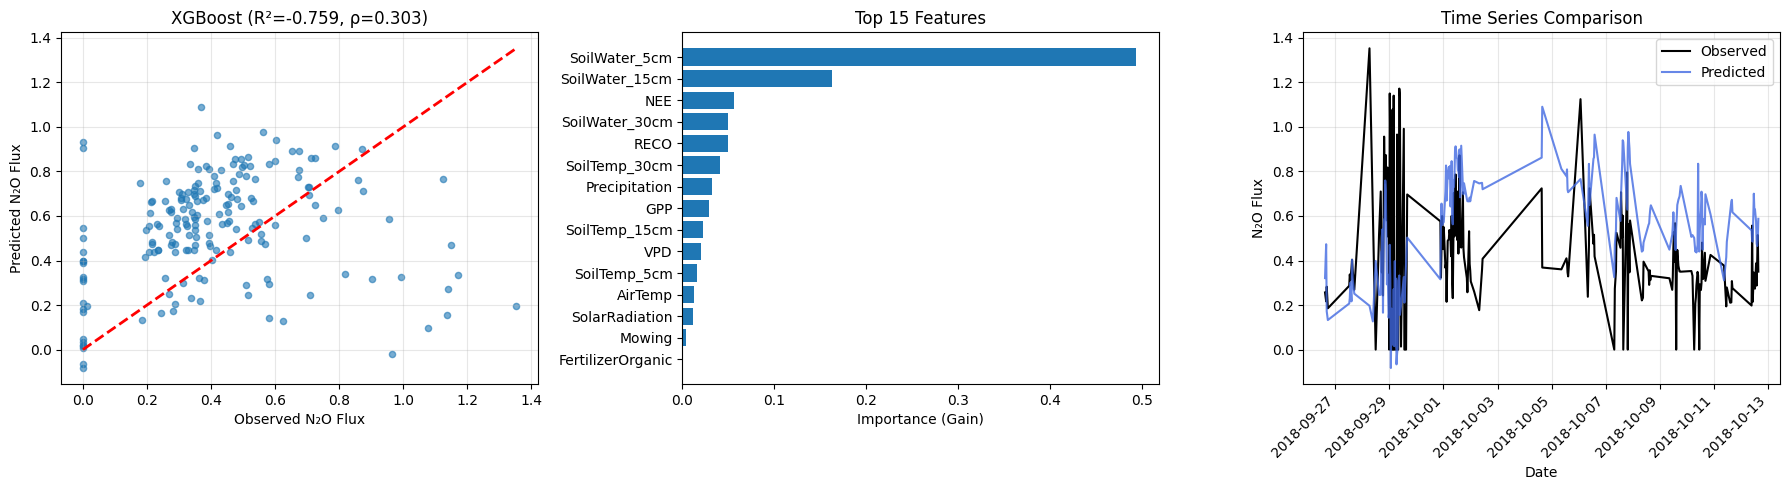


--- HOURLY | target=N2O_Flux_ln | predictors=LAG ---
Train period: 2018-07-12 07:45:00 → 2018-09-06 23:15:00
Test  period: 2018-09-06 23:45:00 → 2019-10-04 23:15:00

Model evaluation:
  R² (linear scale): -0.655
  Spearman ρ:        0.303


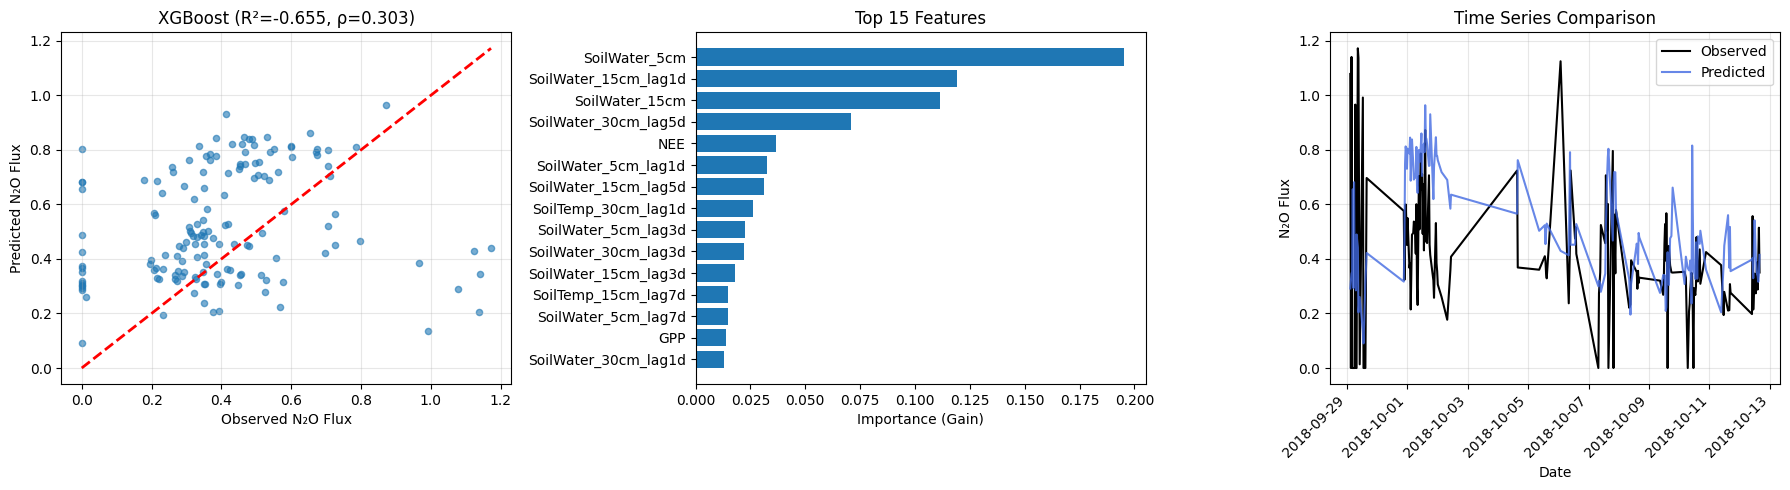


--- DAILY | target=N2O_Flux_ln | predictors=BASE ---
Train period: 0 → 79
Test  period: 80 → 164

Model evaluation:
  R² (linear scale): -12.612
  Spearman ρ:        0.700


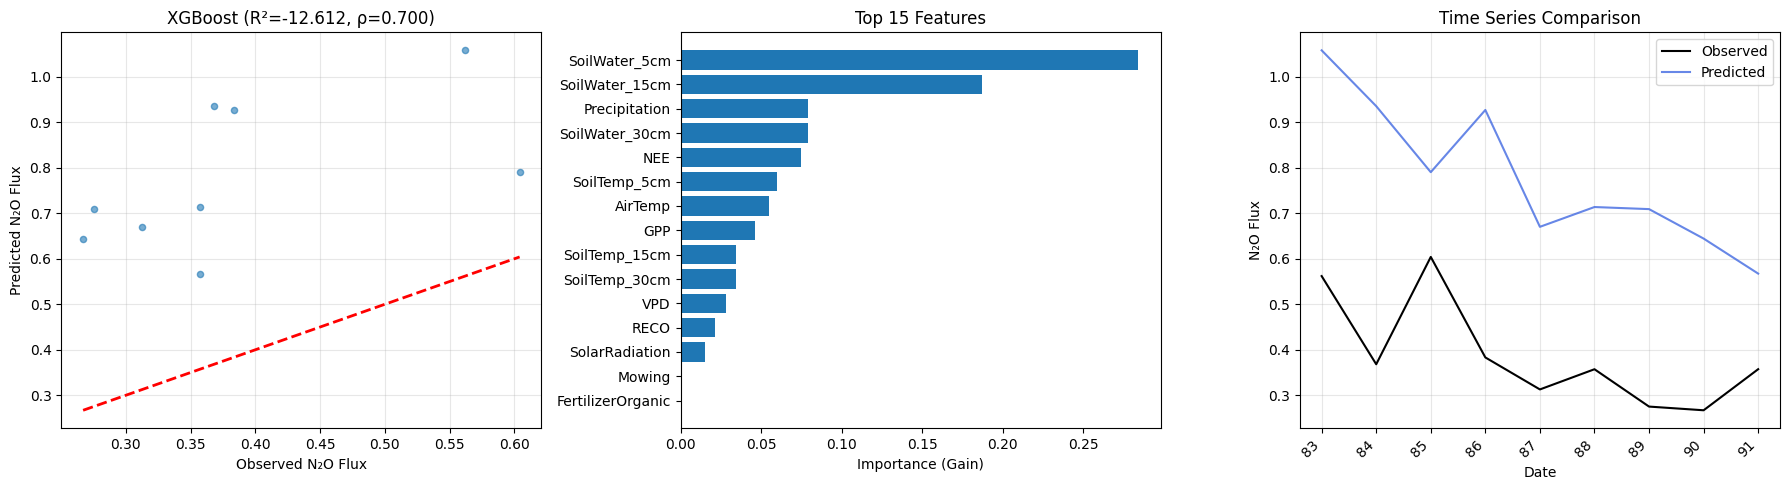


--- DAILY | target=N2O_Flux_ln | predictors=LAG ---
Train period: 0 → 62
Test  period: 63 → 164

Model evaluation:
  R² (linear scale): -25.514
  Spearman ρ:        0.000


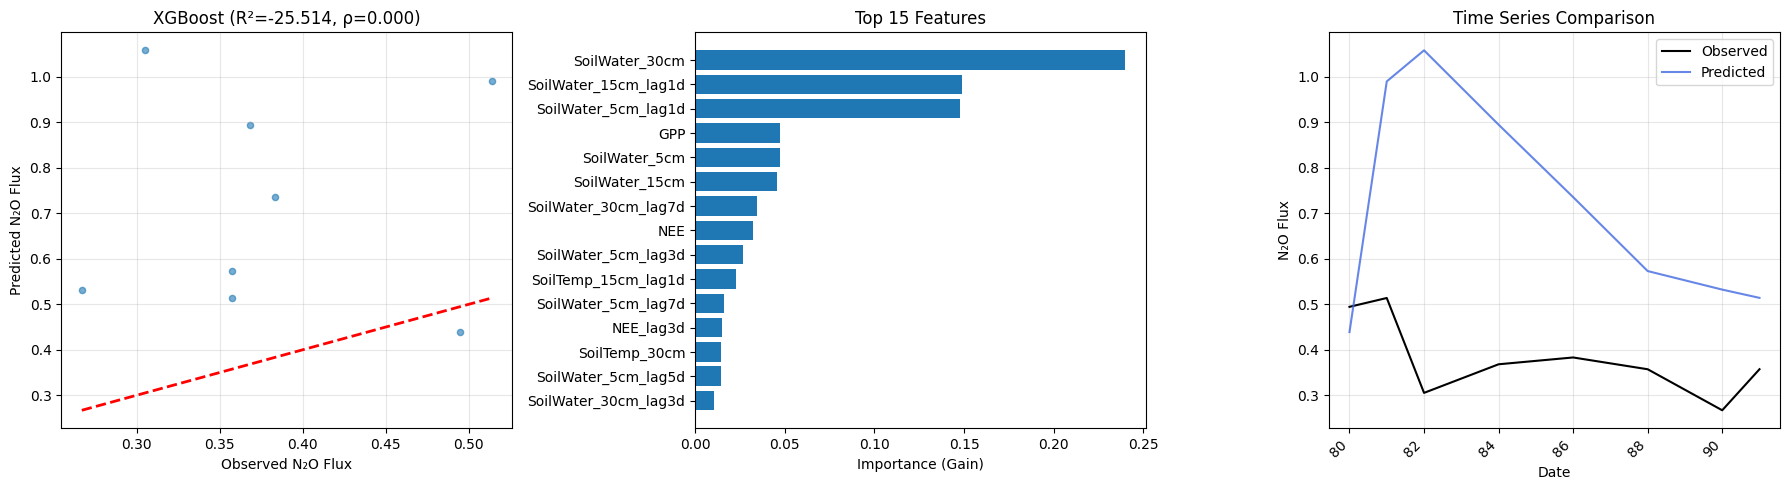


COMPREHENSIVE COMPARISON OF ALL EXPERIMENTS:
Temporal     Predictors   R²       Spearman ρ  
--------------------------------------------------------------------------------
Hourly       Base         -0.759        0.303
Hourly       Lag          -0.655        0.303
Daily        Base         -12.612        0.700
Daily        Lag          -25.514        0.000

IMPROVEMENT FROM BASE TO LAG:
Hourly: R² + 0.104, ρ + 0.000
Daily:  R² +-12.902, ρ +-0.700


In [161]:
# ============================================================================
# OENSINGEN 1
# ============================================================================

print("="*80)
print("EXPERIMENT 1: Oensingen 2018-19")
print("="*80)

# Define base and lag predictors
base_predictors = [
    "Precipitation", "SolarRadiation", "AirTemp", "VPD",
    "SoilWater_5cm", "SoilWater_15cm", "SoilWater_30cm",
    "SoilTemp_5cm", "SoilTemp_15cm", "SoilTemp_30cm",
    "NEE", "GPP", "RECO",
    "Mowing", "FertilizerOrganic", "FertilizerMineral", "SoilCultivation"
]

lag_predictors = [
    # --- Meteorological base variables ---
    "Precipitation", "SolarRadiation", "AirTemp", "VPD",
    "SoilWater_5cm", "SoilWater_15cm", "SoilWater_30cm",
    "SoilTemp_5cm", "SoilTemp_15cm", "SoilTemp_30cm",
    "NEE", "GPP", "RECO",

    # --- Meteorological lag variables ---
    "Precipitation_lag1d", "Precipitation_lag3d", "Precipitation_lag5d", "Precipitation_lag7d",
    "SolarRadiation_lag1d", "SolarRadiation_lag3d", "SolarRadiation_lag5d", "SolarRadiation_lag7d",
    "AirTemp_lag1d", "AirTemp_lag3d", "AirTemp_lag5d", "AirTemp_lag7d",
    "VPD_lag1d", "VPD_lag3d", "VPD_lag5d", "VPD_lag7d",
    "SoilWater_5cm_lag1d", "SoilWater_5cm_lag3d", "SoilWater_5cm_lag5d", "SoilWater_5cm_lag7d",
    "SoilWater_15cm_lag1d", "SoilWater_15cm_lag3d", "SoilWater_15cm_lag5d", "SoilWater_15cm_lag7d",
    "SoilWater_30cm_lag1d", "SoilWater_30cm_lag3d", "SoilWater_30cm_lag5d", "SoilWater_30cm_lag7d",
    "SoilTemp_5cm_lag1d", "SoilTemp_5cm_lag3d", "SoilTemp_5cm_lag5d", "SoilTemp_5cm_lag7d",
    "SoilTemp_15cm_lag1d", "SoilTemp_15cm_lag3d", "SoilTemp_15cm_lag5d", "SoilTemp_15cm_lag7d",
    "SoilTemp_30cm_lag1d", "SoilTemp_30cm_lag3d", "SoilTemp_30cm_lag5d", "SoilTemp_30cm_lag7d",
    "NEE_lag1d", "NEE_lag3d", "NEE_lag5d", "NEE_lag7d",
    "GPP_lag1d", "GPP_lag3d", "GPP_lag5d", "GPP_lag7d",
    "RECO_lag1d", "RECO_lag3d", "RECO_lag5d", "RECO_lag7d",

    # --- Management variables ---
    "Mowing", "FertilizerOrganic", "FertilizerMineral", "SoilCultivation",
    "DaysSince_Mowing", "DaysSince_FertilizerOrganic", "DaysSince_FertilizerMineral",
    "DaysSince_SoilCultivation"
]

# Store results for comparison
all_results = []

# ============================================================================
# HOURLY DATA - BASE PREDICTORS
# ============================================================================
print("\n" + "="*80)
print("--- HOURLY | target=N2O_Flux_ln | predictors=BASE ---")
print("="*80)

results_hourly_base = train_xgb_timeseries(
    df=oensingen_1_lag,
    predictors=base_predictors,
    target="N2O_Flux_ln",
    plot=True
)
all_results.append(("Hourly", "Base", results_hourly_base['r2'], results_hourly_base['spearman_rho']))

# ============================================================================
# HOURLY DATA - LAG PREDICTORS
# ============================================================================
print("\n" + "="*80)
print("--- HOURLY | target=N2O_Flux_ln | predictors=LAG ---")
print("="*80)

results_hourly_lag = train_xgb_timeseries(
    df=oensingen_1_lag,
    predictors=lag_predictors,
    target="N2O_Flux_ln",
    plot=True
)
all_results.append(("Hourly", "Lag", results_hourly_lag['r2'], results_hourly_lag['spearman_rho']))

# ============================================================================
# DAILY DATA - BASE PREDICTORS
# ============================================================================
print("\n" + "="*80)
print("--- DAILY | target=N2O_Flux_ln | predictors=BASE ---")
print("="*80)

results_daily_base = train_xgb_timeseries(
    df=oensingen_1_daily,
    predictors=base_predictors,
    target="N2O_Flux_ln",
    plot=True
)
all_results.append(("Daily", "Base", results_daily_base['r2'], results_daily_base['spearman_rho']))

# ============================================================================
# DAILY DATA - LAG PREDICTORS
# ============================================================================
print("\n" + "="*80)
print("--- DAILY | target=N2O_Flux_ln | predictors=LAG ---")
print("="*80)

results_daily_lag = train_xgb_timeseries(
    df=oensingen_1_daily,
    predictors=lag_predictors,
    target="N2O_Flux_ln",
    plot=True
)
all_results.append(("Daily", "Lag", results_daily_lag['r2'], results_daily_lag['spearman_rho']))

# ============================================================================
# COMPREHENSIVE COMPARISON
# ============================================================================
print("\n" + "="*80)
print("COMPREHENSIVE COMPARISON OF ALL EXPERIMENTS:")
print("="*80)
print(f"{'Temporal':<12} {'Predictors':<12} {'R²':<8} {'Spearman ρ':<12}")
print("-"*80)
for temp, pred, r2, rho in all_results:
    print(f"{temp:<12} {pred:<12} {r2:>6.3f}   {rho:>10.3f}")

print("\n" + "="*80)
print("IMPROVEMENT FROM BASE TO LAG:")
print("="*80)
print(f"Hourly: R² +{(results_hourly_lag['r2'] - results_hourly_base['r2']):>6.3f}, ρ +{(results_hourly_lag['spearman_rho'] - results_hourly_base['spearman_rho']):>6.3f}")
print(f"Daily:  R² +{(results_daily_lag['r2'] - results_daily_base['r2']):>6.3f}, ρ +{(results_daily_lag['spearman_rho'] - results_daily_base['spearman_rho']):>6.3f}")

# Experiment 2: Oensingen 2021-23

In [162]:
# FIX TIMESTAMP
oensingen_2_lag['Timestamp'] = pd.to_datetime(oensingen_2_lag['Timestamp'])
oensingen_2_lag = oensingen_2_lag.set_index('Timestamp').sort_index()

oensingen_2_daily['Date'] = pd.to_datetime(oensingen_2_daily['Date'])
oensingen_2_daily = oensingen_2_daily.sort_values('Date')


# PREDICTOR SETS
predictor_sets = {
    "base": [
        "Precipitation", "SolarRadiation", "AirTemp", "VPD",
        "SoilWater_5cm", "SoilWater_15cm", "SoilWater_30cm", "SoilTemp_5cm", "SoilTemp_15cm", "SoilTemp_30cm",
        "NEE", "GPP", "RECO",
        "Mowing", "FertilizerOrganic", "FertilizerMineral", "SoilCultivation"
    ],
    
    "lag": [
        "Precipitation", "SolarRadiation", "AirTemp", "VPD",
        "SoilWater_5cm", "SoilWater_15cm", "SoilWater_30cm",
        "SoilTemp_5cm", "SoilTemp_15cm", "SoilTemp_30cm",
        "NEE", "GPP", "RECO",
        "Precipitation_lag1d", "Precipitation_lag3d", "Precipitation_lag5d", "Precipitation_lag7d",
        "SolarRadiation_lag1d", "SolarRadiation_lag3d", "SolarRadiation_lag5d", "SolarRadiation_lag7d",
        "AirTemp_lag1d", "AirTemp_lag3d", "AirTemp_lag5d", "AirTemp_lag7d",
        "VPD_lag1d", "VPD_lag3d", "VPD_lag5d", "VPD_lag7d",
        "SoilWater_5cm_lag1d", "SoilWater_5cm_lag3d", "SoilWater_5cm_lag5d", "SoilWater_5cm_lag7d",
        "SoilWater_15cm_lag1d", "SoilWater_15cm_lag3d", "SoilWater_15cm_lag5d", "SoilWater_15cm_lag7d",
        "SoilWater_30cm_lag1d", "SoilWater_30cm_lag3d", "SoilWater_30cm_lag5d", "SoilWater_30cm_lag7d",
        "SoilTemp_5cm_lag1d", "SoilTemp_5cm_lag3d", "SoilTemp_5cm_lag5d", "SoilTemp_5cm_lag7d",
        "SoilTemp_15cm_lag1d", "SoilTemp_15cm_lag3d", "SoilTemp_15cm_lag5d", "SoilTemp_15cm_lag7d",
        "SoilTemp_30cm_lag1d", "SoilTemp_30cm_lag3d", "SoilTemp_30cm_lag5d", "SoilTemp_30cm_lag7d",
        "NEE_lag1d", "NEE_lag3d", "NEE_lag5d", "NEE_lag7d",
        "GPP_lag1d", "GPP_lag3d", "GPP_lag5d", "GPP_lag7d",
        "RECO_lag1d", "RECO_lag3d", "RECO_lag5d", "RECO_lag7d",
        "Mowing", "FertilizerOrganic", "FertilizerMineral", "SoilCultivation",
        "DaysSince_Mowing", "DaysSince_FertilizerOrganic", "DaysSince_FertilizerMineral",
        "DaysSince_SoilCultivation"
    ],
    
    "main": ["AirTemp", "VPD", "SoilTemp_5cm", "SoilTemp_15cm", "RECO", "SolarRadiation"]
}

# DATASETS
datasets = {
    "Hourly": oensingen_2_lag,
    "Daily": oensingen_2_daily
}

targets = ["N2O_Flux", "N2O_Flux_ln"]

In [163]:
# RUN ALL EXPERIMENTS
results = []

for df_name, df in datasets.items():
    for target in targets:
        for set_name, preds in predictor_sets.items():
            print(f"\n{df_name} | {target} | {set_name}")
            
            try:
                # PREP DATA
                X = df[preds]
                y = df[target]
                mask = X.notna().all(axis=1) & y.notna()
                X, y = X[mask], y[mask]
                
                # OFFSET
                offset = abs(y.min()) + 1e-6
                y = y + offset
                
                # SPLIT
                split = int(len(X) * 0.9)
                X_train, X_test = X.iloc[:split], X.iloc[split:]
                y_train, y_test = y.iloc[:split], y.iloc[split:]
                
                # TRAIN
                model = XGBRegressor(
                    max_depth=6,
                    learning_rate=0.1,
                    n_estimators=300,
                    subsample=0.8,
                    colsample_bytree=0.8,
                    random_state=42,
                    n_jobs=-1
                )
                model.fit(X_train, y_train, verbose=False)
                
                # PREDICT
                y_pred = model.predict(X_test) - offset
                y_test = y_test - offset
                
                # EVALUATE
                r2 = r2_score(y_test, y_pred)
                rho, _ = spearmanr(y_test, y_pred)
                
                results.append({
                    "Dataset": df_name,
                    "Target": target,
                    "Predictors": set_name,
                    "R2": r2,
                    "Spearman": rho
                })
                
                print(f"  R²={r2:.3f}, ρ={rho:.3f}")
                
            except Exception as e:
                print(f"  ERROR: {e}")
                results.append({
                    "Dataset": df_name,
                    "Target": target,
                    "Predictors": set_name,
                    "R2": None,
                    "Spearman": None
                })

# DISPLAY RESULTS
results_df = pd.DataFrame(results)
print("\n" + "="*60)
print("=== Summary Results ===")
print(results_df.round(3))


Hourly | N2O_Flux | base
  R²=-0.062, ρ=0.494

Hourly | N2O_Flux | lag
  R²=-0.417, ρ=0.315

Hourly | N2O_Flux | main
  R²=-1.809, ρ=-0.022

Hourly | N2O_Flux_ln | base
  R²=0.008, ρ=0.356

Hourly | N2O_Flux_ln | lag
  R²=-0.242, ρ=0.227

Hourly | N2O_Flux_ln | main
  R²=-0.590, ρ=-0.095

Daily | N2O_Flux | base
  R²=0.516, ρ=0.831

Daily | N2O_Flux | lag
  R²=0.306, ρ=0.776

Daily | N2O_Flux | main
  R²=-0.822, ρ=0.216

Daily | N2O_Flux_ln | base
  R²=0.649, ρ=0.869

Daily | N2O_Flux_ln | lag
  R²=0.335, ρ=0.757

Daily | N2O_Flux_ln | main
  R²=-0.511, ρ=0.125

=== Summary Results ===
   Dataset       Target Predictors     R2  Spearman
0   Hourly     N2O_Flux       base -0.062     0.494
1   Hourly     N2O_Flux        lag -0.417     0.315
2   Hourly     N2O_Flux       main -1.809    -0.022
3   Hourly  N2O_Flux_ln       base  0.008     0.356
4   Hourly  N2O_Flux_ln        lag -0.242     0.227
5   Hourly  N2O_Flux_ln       main -0.590    -0.095
6    Daily     N2O_Flux       base  0.516 

In [164]:
def train_xgb_timeseries(df, predictors, target, test_size=0.1, n_estimators=300, random_state=42, plot=True):
    """
    Train XGBoost on time-series data using chronological split.
    
    Now includes a time series comparison plot showing observed vs predicted values over time.
    """
    # ENSURE TIME ORDER
    df = df.sort_index().copy()
    
    # EXTRACT FEATURES/TARGET
    X = df[predictors]
    y = df[target]
    
    # HANDLE NaNs
    mask = X.notna().all(axis=1) & y.notna()
    X, y = X[mask], y[mask]
    
    # OFFSET FOR POSITIVITY
    offset = abs(y.min()) + 1e-6
    y_shifted = y + offset
    
    # CHRONOLOGICAL SPLIT
    split_idx = int(len(X) * (1 - test_size))
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y_shifted.iloc[:split_idx], y_shifted.iloc[split_idx:]
    
    # Store test dates for time series plot
    test_dates = X_test.index
    
    time_train = (df.index.min(), df.index[:split_idx].max())
    time_test = (df.index[split_idx], df.index.max())
    
    print(f"Train period: {time_train[0]} → {time_train[1]}")
    print(f"Test  period: {time_test[0]} → {time_test[1]}")
    
    # TRAIN MODEL
    model = XGBRegressor(
        n_estimators=n_estimators,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=random_state,
        n_jobs=-1
    )
    model.fit(X_train, y_train, verbose=False)
    
    # PREDICTIONS
    y_pred = model.predict(X_test)
    
    # REVERT OFFSET
    y_pred_lin = y_pred - offset
    y_test_lin = y_test - offset
    
    # EVALUATION
    r2 = r2_score(y_test_lin, y_pred_lin)
    rho, _ = spearmanr(y_test_lin, y_pred_lin)
    
    # FEATURE IMPORTANCE
    importances = pd.Series(model.feature_importances_, index=predictors).sort_values(ascending=False)
    
    print("\nModel evaluation:")
    print(f"  R² (linear scale): {r2:.3f}")
    print(f"  Spearman ρ:        {rho:.3f}")
    
    # PLOT
    if plot:
        # Create 3-subplot figure: scatter, feature importance, and TIME SERIES
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))
        
        # 1. Scatter plot
        axes[0].scatter(y_test_lin, y_pred_lin, alpha=0.6, s=20)
        min_val, max_val = y_test_lin.min(), y_test_lin.max()
        axes[0].plot([min_val, max_val], [min_val, max_val], "r--", lw=2)
        axes[0].set_xlabel("Observed N₂O Flux")
        axes[0].set_ylabel("Predicted N₂O Flux")
        axes[0].set_title(f"XGBoost (R²={r2:.3f}, ρ={rho:.3f})")
        axes[0].grid(True, alpha=0.3)
        
        # 2. Feature importance
        top_features = importances.head(15)
        axes[1].barh(range(len(top_features)), top_features.values)
        axes[1].set_yticks(range(len(top_features)))
        axes[1].set_yticklabels(top_features.index)
        axes[1].set_xlabel("Importance (Gain)")
        axes[1].set_title("Top 15 Features")
        axes[1].invert_yaxis()
        
        # 3. TIME SERIES COMPARISON (NEW!)
        axes[2].plot(test_dates, y_test_lin.values, label="Observed", color="black", lw=1.5)
        axes[2].plot(test_dates, y_pred_lin, label="Predicted", color="royalblue", lw=1.5, alpha=0.8)
        axes[2].set_xlabel("Date")
        axes[2].set_ylabel("N₂O Flux")
        axes[2].set_title("Time Series Comparison")
        axes[2].legend()
        axes[2].grid(True, alpha=0.3)
        
        # Rotate x-axis labels for better readability
        plt.setp(axes[2].xaxis.get_majorticklabels(), rotation=45, ha='right')
        
        plt.tight_layout()
        plt.show()
    
    return {
        "model": model,
        "r2": r2,
        "spearman_rho": rho,
        "feature_importance": importances,
        "y_test": y_test_lin,
        "y_pred": y_pred_lin,
        "test_dates": test_dates,  # Also return test dates
    }

EXPERIMENT 2: Oensingen 2021-23

--- HOURLY | target=N2O_Flux_ln | predictors=BASE ---
Train period: 2022-08-30 11:45:00 → 2023-08-15 09:15:00
Test  period: 2023-08-15 14:45:00 → 2023-10-05 12:15:00

Model evaluation:
  R² (linear scale): 0.008
  Spearman ρ:        0.356


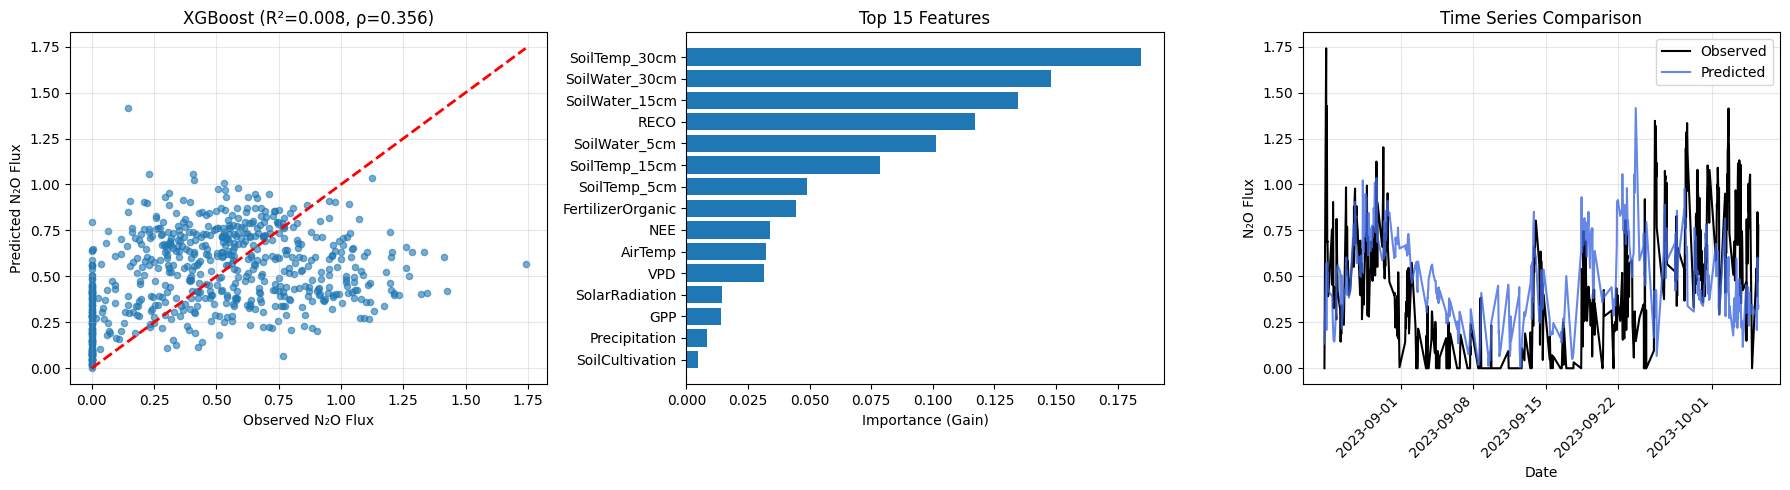


--- HOURLY | target=N2O_Flux_ln | predictors=LAG ---
Train period: 2022-08-30 11:45:00 → 2023-08-05 15:45:00
Test  period: 2023-08-05 16:15:00 → 2023-10-05 12:15:00

Model evaluation:
  R² (linear scale): -0.242
  Spearman ρ:        0.227


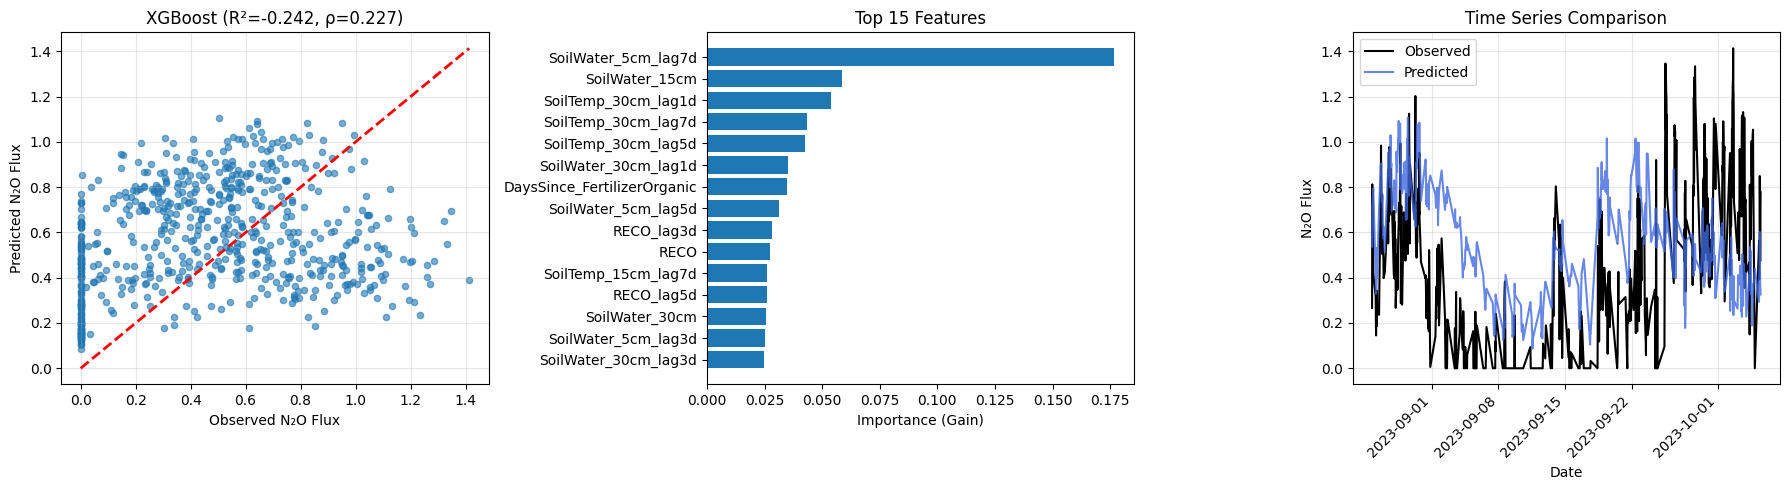


--- DAILY | target=N2O_Flux_ln | predictors=BASE ---
Train period: 0 → 335
Test  period: 336 → 373

Model evaluation:
  R² (linear scale): 0.649
  Spearman ρ:        0.869


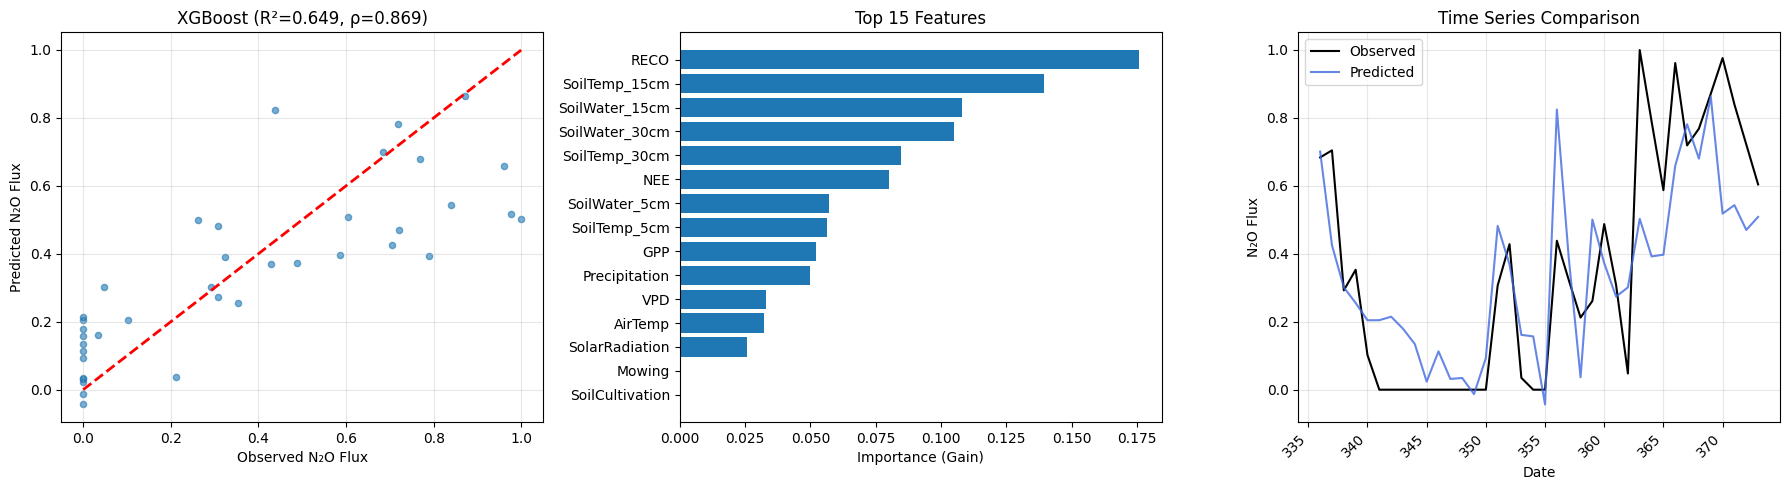


--- DAILY | target=N2O_Flux_ln | predictors=LAG ---
Train period: 0 → 284
Test  period: 285 → 373

Model evaluation:
  R² (linear scale): 0.335
  Spearman ρ:        0.757


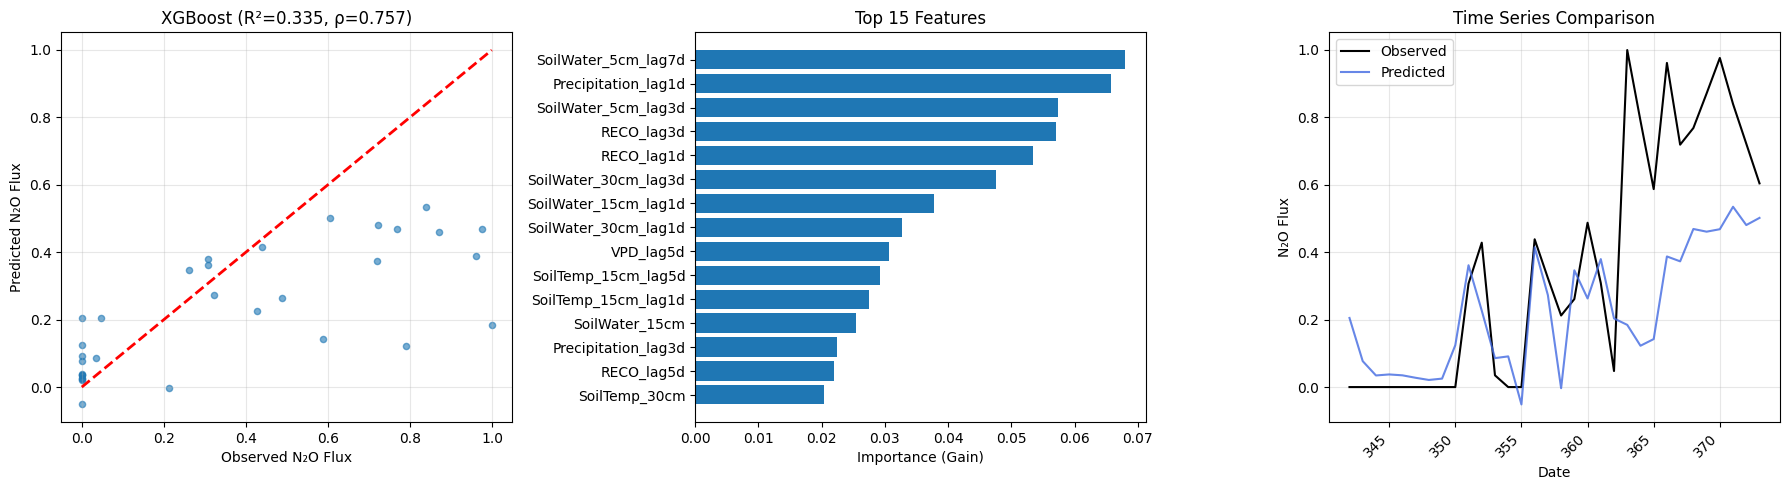


COMPREHENSIVE COMPARISON OF ALL EXPERIMENTS:
Temporal     Predictors   R²       Spearman ρ  
--------------------------------------------------------------------------------
Hourly       Base          0.008        0.356
Hourly       Lag          -0.242        0.227
Daily        Base          0.649        0.869
Daily        Lag           0.335        0.757

IMPROVEMENT FROM BASE TO LAG:
Hourly: R² +-0.250, ρ +-0.129
Daily:  R² +-0.314, ρ +-0.112


In [165]:
# ============================================================================
# OENSINGEN 2
# ============================================================================

print("="*80)
print("EXPERIMENT 2: Oensingen 2021-23")
print("="*80)

# Define base and lag predictors
base_predictors = [
    "Precipitation", "SolarRadiation", "AirTemp", "VPD",
    "SoilWater_5cm", "SoilWater_15cm", "SoilWater_30cm",
    "SoilTemp_5cm", "SoilTemp_15cm", "SoilTemp_30cm",
    "NEE", "GPP", "RECO",
    "Mowing", "FertilizerOrganic", "FertilizerMineral", "SoilCultivation"
]

lag_predictors = [
    # --- Meteorological base variables ---
    "Precipitation", "SolarRadiation", "AirTemp", "VPD",
    "SoilWater_5cm", "SoilWater_15cm", "SoilWater_30cm",
    "SoilTemp_5cm", "SoilTemp_15cm", "SoilTemp_30cm",
    "NEE", "GPP", "RECO",

    # --- Meteorological lag variables ---
    "Precipitation_lag1d", "Precipitation_lag3d", "Precipitation_lag5d", "Precipitation_lag7d",
    "SolarRadiation_lag1d", "SolarRadiation_lag3d", "SolarRadiation_lag5d", "SolarRadiation_lag7d",
    "AirTemp_lag1d", "AirTemp_lag3d", "AirTemp_lag5d", "AirTemp_lag7d",
    "VPD_lag1d", "VPD_lag3d", "VPD_lag5d", "VPD_lag7d",
    "SoilWater_5cm_lag1d", "SoilWater_5cm_lag3d", "SoilWater_5cm_lag5d", "SoilWater_5cm_lag7d",
    "SoilWater_15cm_lag1d", "SoilWater_15cm_lag3d", "SoilWater_15cm_lag5d", "SoilWater_15cm_lag7d",
    "SoilWater_30cm_lag1d", "SoilWater_30cm_lag3d", "SoilWater_30cm_lag5d", "SoilWater_30cm_lag7d",
    "SoilTemp_5cm_lag1d", "SoilTemp_5cm_lag3d", "SoilTemp_5cm_lag5d", "SoilTemp_5cm_lag7d",
    "SoilTemp_15cm_lag1d", "SoilTemp_15cm_lag3d", "SoilTemp_15cm_lag5d", "SoilTemp_15cm_lag7d",
    "SoilTemp_30cm_lag1d", "SoilTemp_30cm_lag3d", "SoilTemp_30cm_lag5d", "SoilTemp_30cm_lag7d",
    "NEE_lag1d", "NEE_lag3d", "NEE_lag5d", "NEE_lag7d",
    "GPP_lag1d", "GPP_lag3d", "GPP_lag5d", "GPP_lag7d",
    "RECO_lag1d", "RECO_lag3d", "RECO_lag5d", "RECO_lag7d",

    # --- Management variables ---
    "Mowing", "FertilizerOrganic", "FertilizerMineral", "SoilCultivation",
    "DaysSince_Mowing", "DaysSince_FertilizerOrganic", "DaysSince_FertilizerMineral",
    "DaysSince_SoilCultivation"
]

# Store results for comparison
all_results = []

# ============================================================================
# HOURLY DATA - BASE PREDICTORS
# ============================================================================
print("\n" + "="*80)
print("--- HOURLY | target=N2O_Flux_ln | predictors=BASE ---")
print("="*80)

results_hourly_base = train_xgb_timeseries(
    df=oensingen_2_lag,
    predictors=base_predictors,
    target="N2O_Flux_ln",
    plot=True
)
all_results.append(("Hourly", "Base", results_hourly_base['r2'], results_hourly_base['spearman_rho']))

# ============================================================================
# HOURLY DATA - LAG PREDICTORS
# ============================================================================
print("\n" + "="*80)
print("--- HOURLY | target=N2O_Flux_ln | predictors=LAG ---")
print("="*80)

results_hourly_lag = train_xgb_timeseries(
    df=oensingen_2_lag,
    predictors=lag_predictors,
    target="N2O_Flux_ln",
    plot=True
)
all_results.append(("Hourly", "Lag", results_hourly_lag['r2'], results_hourly_lag['spearman_rho']))

# ============================================================================
# DAILY DATA - BASE PREDICTORS
# ============================================================================
print("\n" + "="*80)
print("--- DAILY | target=N2O_Flux_ln | predictors=BASE ---")
print("="*80)

results_daily_base = train_xgb_timeseries(
    df=oensingen_2_daily,
    predictors=base_predictors,
    target="N2O_Flux_ln",
    plot=True
)
all_results.append(("Daily", "Base", results_daily_base['r2'], results_daily_base['spearman_rho']))

# ============================================================================
# DAILY DATA - LAG PREDICTORS
# ============================================================================
print("\n" + "="*80)
print("--- DAILY | target=N2O_Flux_ln | predictors=LAG ---")
print("="*80)

results_daily_lag = train_xgb_timeseries(
    df=oensingen_2_daily,
    predictors=lag_predictors,
    target="N2O_Flux_ln",
    plot=True
)
all_results.append(("Daily", "Lag", results_daily_lag['r2'], results_daily_lag['spearman_rho']))

# ============================================================================
# COMPREHENSIVE COMPARISON
# ============================================================================
print("\n" + "="*80)
print("COMPREHENSIVE COMPARISON OF ALL EXPERIMENTS:")
print("="*80)
print(f"{'Temporal':<12} {'Predictors':<12} {'R²':<8} {'Spearman ρ':<12}")
print("-"*80)
for temp, pred, r2, rho in all_results:
    print(f"{temp:<12} {pred:<12} {r2:>6.3f}   {rho:>10.3f}")

print("\n" + "="*80)
print("IMPROVEMENT FROM BASE TO LAG:")
print("="*80)
print(f"Hourly: R² +{(results_hourly_lag['r2'] - results_hourly_base['r2']):>6.3f}, ρ +{(results_hourly_lag['spearman_rho'] - results_hourly_base['spearman_rho']):>6.3f}")
print(f"Daily:  R² +{(results_daily_lag['r2'] - results_daily_base['r2']):>6.3f}, ρ +{(results_daily_lag['spearman_rho'] - results_daily_base['spearman_rho']):>6.3f}")

# Experiment 3: Aeschi dataset

In [166]:
# FIX TIMESTAMP
aeschi_lag['Timestamp'] = pd.to_datetime(aeschi_lag['Timestamp'])
aeschi_lag = aeschi_lag.set_index('Timestamp').sort_index()

aeschi_daily['Date'] = pd.to_datetime(aeschi_daily['Date'])
aeschi_daily = aeschi_daily.set_index('Date').sort_index()

# PREDICTOR SETS
predictor_sets = {
    "base": [
        "Precipitation", "SolarRadiation", "AirTemp", "VPD",
        "SoilWater_5cm", "SoilWater_15cm", "SoilWater_30cm",
        "SoilTemp_5cm", "SoilTemp_15cm", "SoilTemp_30cm",
        "NEE", "GPP", "RECO", "Mowing"
    ],
    
    "lag": [
        "Precipitation", "SolarRadiation", "AirTemp", "VPD",
        "SoilWater_5cm", "SoilWater_15cm", "SoilWater_30cm",
        "SoilTemp_5cm", "SoilTemp_15cm", "SoilTemp_30cm",
        "NEE", "GPP", "RECO",
        "Precipitation_lag1d", "Precipitation_lag3d", "Precipitation_lag5d", "Precipitation_lag7d",
        "SolarRadiation_lag1d", "SolarRadiation_lag3d", "SolarRadiation_lag5d", "SolarRadiation_lag7d",
        "AirTemp_lag1d", "AirTemp_lag3d", "AirTemp_lag5d", "AirTemp_lag7d",
        "VPD_lag1d", "VPD_lag3d", "VPD_lag5d", "VPD_lag7d",
        "SoilWater_5cm_lag1d", "SoilWater_5cm_lag3d", "SoilWater_5cm_lag5d", "SoilWater_5cm_lag7d",
        "SoilWater_15cm_lag1d", "SoilWater_15cm_lag3d", "SoilWater_15cm_lag5d", "SoilWater_15cm_lag7d",
        "SoilWater_30cm_lag1d", "SoilWater_30cm_lag3d", "SoilWater_30cm_lag5d", "SoilWater_30cm_lag7d",
        "SoilTemp_5cm_lag1d", "SoilTemp_5cm_lag3d", "SoilTemp_5cm_lag5d", "SoilTemp_5cm_lag7d",
        "SoilTemp_15cm_lag1d", "SoilTemp_15cm_lag3d", "SoilTemp_15cm_lag5d", "SoilTemp_15cm_lag7d",
        "SoilTemp_30cm_lag1d", "SoilTemp_30cm_lag3d", "SoilTemp_30cm_lag5d", "SoilTemp_30cm_lag7d",
        "NEE_lag1d", "NEE_lag3d", "NEE_lag5d", "NEE_lag7d",
        "GPP_lag1d", "GPP_lag3d", "GPP_lag5d", "GPP_lag7d",
        "RECO_lag1d", "RECO_lag3d", "RECO_lag5d", "RECO_lag7d",
        "Mowing"
    ],
    
    "main": ["AirTemp", "VPD", "SoilTemp_5cm", "SoilTemp_15cm", "RECO", "SolarRadiation"]
}

# DATASETS
datasets = {
    "Hourly": aeschi_lag,
    "Daily": aeschi_daily
}

targets = ["N2O_Flux", "N2O_Flux_ln"]

In [167]:
# RUN ALL EXPERIMENTS
results = []

for df_name, df in datasets.items():
    for target in targets:
        for set_name, preds in predictor_sets.items():
            print(f"\n{df_name} | {target} | {set_name}")
            
            try:
                # PREP DATA
                X = df[preds]
                y = df[target]
                mask = X.notna().all(axis=1) & y.notna()
                X, y = X[mask], y[mask]
                
                # OFFSET
                offset = abs(y.min()) + 1e-6
                y = y + offset
                
                # SPLIT
                split = int(len(X) * 0.9)
                X_train, X_test = X.iloc[:split], X.iloc[split:]
                y_train, y_test = y.iloc[:split], y.iloc[split:]
                
                # TRAIN
                model = XGBRegressor(
                    max_depth=6,
                    learning_rate=0.1,
                    n_estimators=300,
                    subsample=0.8,
                    colsample_bytree=0.8,
                    random_state=42,
                    n_jobs=-1
                )
                model.fit(X_train, y_train, verbose=False)
                
                # PREDICT
                y_pred = model.predict(X_test) - offset
                y_test = y_test - offset
                
                # EVALUATE
                r2 = r2_score(y_test, y_pred)
                rho, _ = spearmanr(y_test, y_pred)
                
                results.append({
                    "Dataset": df_name,
                    "Target": target,
                    "Predictors": set_name,
                    "R2": r2,
                    "Spearman": rho
                })
                
                print(f"  R²={r2:.3f}, ρ={rho:.3f}")
                
            except Exception as e:
                print(f"  ERROR: {e}")
                results.append({
                    "Dataset": df_name,
                    "Target": target,
                    "Predictors": set_name,
                    "R2": None,
                    "Spearman": None
                })

# DISPLAY RESULTS
results_df = pd.DataFrame(results)
print("\n" + "="*60)
print("=== Summary Results ===")
print(results_df.round(3))


Hourly | N2O_Flux | base
  R²=-2.236, ρ=0.139

Hourly | N2O_Flux | lag
  R²=-0.606, ρ=0.140

Hourly | N2O_Flux | main
  R²=-3.195, ρ=0.077

Hourly | N2O_Flux_ln | base
  R²=-2.066, ρ=0.080

Hourly | N2O_Flux_ln | lag
  R²=-0.434, ρ=0.103

Hourly | N2O_Flux_ln | main
  R²=-1.772, ρ=0.100

Daily | N2O_Flux | base
  R²=-3.423, ρ=0.357

Daily | N2O_Flux | lag
  R²=-13.363, ρ=0.257

Daily | N2O_Flux | main
  R²=-4.736, ρ=0.000

Daily | N2O_Flux_ln | base
  R²=-2.135, ρ=0.214

Daily | N2O_Flux_ln | lag
  R²=-2.167, ρ=0.143

Daily | N2O_Flux_ln | main
  R²=0.309, ρ=0.429

=== Summary Results ===
   Dataset       Target Predictors      R2  Spearman
0   Hourly     N2O_Flux       base  -2.236     0.139
1   Hourly     N2O_Flux        lag  -0.606     0.140
2   Hourly     N2O_Flux       main  -3.195     0.077
3   Hourly  N2O_Flux_ln       base  -2.066     0.080
4   Hourly  N2O_Flux_ln        lag  -0.434     0.103
5   Hourly  N2O_Flux_ln       main  -1.772     0.100
6    Daily     N2O_Flux       ba

In [168]:
def train_xgb_timeseries(df, predictors, target, test_size=0.1, n_estimators=300, random_state=42, plot=True):
    """
    Train XGBoost on time-series data using chronological split.
    
    Now includes a time series comparison plot showing observed vs predicted values over time.
    """
    # ENSURE TIME ORDER
    df = df.sort_index().copy()
    
    # EXTRACT FEATURES/TARGET
    X = df[predictors]
    y = df[target]
    
    # HANDLE NaNs
    mask = X.notna().all(axis=1) & y.notna()
    X, y = X[mask], y[mask]
    
    # OFFSET FOR POSITIVITY
    offset = abs(y.min()) + 1e-6
    y_shifted = y + offset
    
    # CHRONOLOGICAL SPLIT
    split_idx = int(len(X) * (1 - test_size))
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y_shifted.iloc[:split_idx], y_shifted.iloc[split_idx:]
    
    # Store test dates for time series plot
    test_dates = X_test.index
    
    time_train = (df.index.min(), df.index[:split_idx].max())
    time_test = (df.index[split_idx], df.index.max())
    
    print(f"Train period: {time_train[0]} → {time_train[1]}")
    print(f"Test  period: {time_test[0]} → {time_test[1]}")
    
    # TRAIN MODEL
    model = XGBRegressor(
        n_estimators=n_estimators,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=random_state,
        n_jobs=-1
    )
    model.fit(X_train, y_train, verbose=False)
    
    # PREDICTIONS
    y_pred = model.predict(X_test)
    
    # REVERT OFFSET
    y_pred_lin = y_pred - offset
    y_test_lin = y_test - offset
    
    # EVALUATION
    r2 = r2_score(y_test_lin, y_pred_lin)
    rho, _ = spearmanr(y_test_lin, y_pred_lin)
    
    # FEATURE IMPORTANCE
    importances = pd.Series(model.feature_importances_, index=predictors).sort_values(ascending=False)
    
    print("\nModel evaluation:")
    print(f"  R² (linear scale): {r2:.3f}")
    print(f"  Spearman ρ:        {rho:.3f}")
    
    # PLOT
    if plot:
        # Create 3-subplot figure: scatter, feature importance, and TIME SERIES
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))
        
        # 1. Scatter plot
        axes[0].scatter(y_test_lin, y_pred_lin, alpha=0.6, s=20)
        min_val, max_val = y_test_lin.min(), y_test_lin.max()
        axes[0].plot([min_val, max_val], [min_val, max_val], "r--", lw=2)
        axes[0].set_xlabel("Observed N₂O Flux")
        axes[0].set_ylabel("Predicted N₂O Flux")
        axes[0].set_title(f"XGBoost (R²={r2:.3f}, ρ={rho:.3f})")
        axes[0].grid(True, alpha=0.3)
        
        # 2. Feature importance
        top_features = importances.head(15)
        axes[1].barh(range(len(top_features)), top_features.values)
        axes[1].set_yticks(range(len(top_features)))
        axes[1].set_yticklabels(top_features.index)
        axes[1].set_xlabel("Importance (Gain)")
        axes[1].set_title("Top 15 Features")
        axes[1].invert_yaxis()
        
        # 3. TIME SERIES COMPARISON (NEW!)
        axes[2].plot(test_dates, y_test_lin.values, label="Observed", color="black", lw=1.5)
        axes[2].plot(test_dates, y_pred_lin, label="Predicted", color="royalblue", lw=1.5, alpha=0.8)
        axes[2].set_xlabel("Date")
        axes[2].set_ylabel("N₂O Flux")
        axes[2].set_title("Time Series Comparison")
        axes[2].legend()
        axes[2].grid(True, alpha=0.3)
        
        # Rotate x-axis labels for better readability
        plt.setp(axes[2].xaxis.get_majorticklabels(), rotation=45, ha='right')
        
        plt.tight_layout()
        plt.show()
    
    return {
        "model": model,
        "r2": r2,
        "spearman_rho": rho,
        "feature_importance": importances,
        "y_test": y_test_lin,
        "y_pred": y_pred_lin,
        "test_dates": test_dates,  # Also return test dates
    }

EXPERIMENT 3: Aeschi 2019-20

--- HOURLY | target=N2O_Flux_ln | predictors=BASE ---
Train period: 2019-07-03 14:45:00 → 2020-10-27 03:15:00
Test  period: 2020-10-27 03:45:00 → 2020-11-02 17:45:00

Model evaluation:
  R² (linear scale): -2.066
  Spearman ρ:        0.080


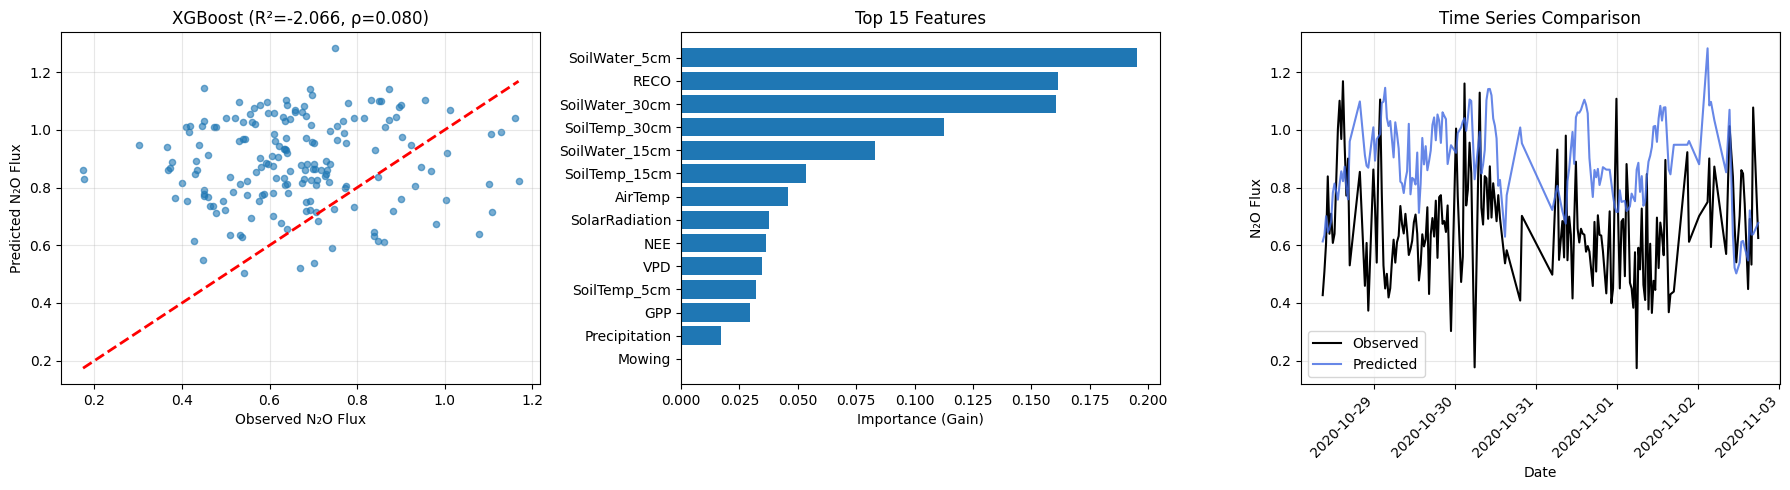


--- HOURLY | target=N2O_Flux_ln | predictors=LAG ---
Train period: 2019-07-03 14:45:00 → 2020-10-05 03:15:00
Test  period: 2020-10-05 04:45:00 → 2020-11-02 17:45:00

Model evaluation:
  R² (linear scale): -0.434
  Spearman ρ:        0.103


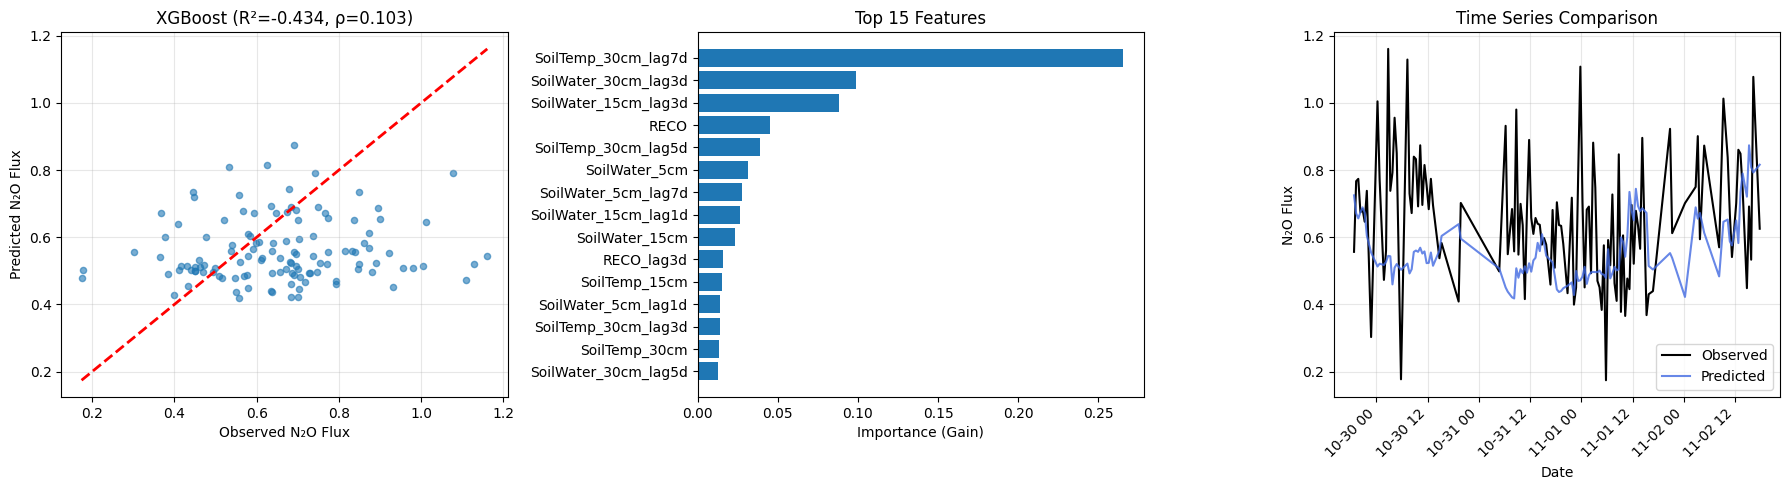


--- DAILY | target=N2O_Flux_ln | predictors=BASE ---
Train period: 2019-07-03 00:00:00 → 2020-10-26 00:00:00
Test  period: 2020-10-27 00:00:00 → 2020-11-02 00:00:00

Model evaluation:
  R² (linear scale): -2.135
  Spearman ρ:        0.214


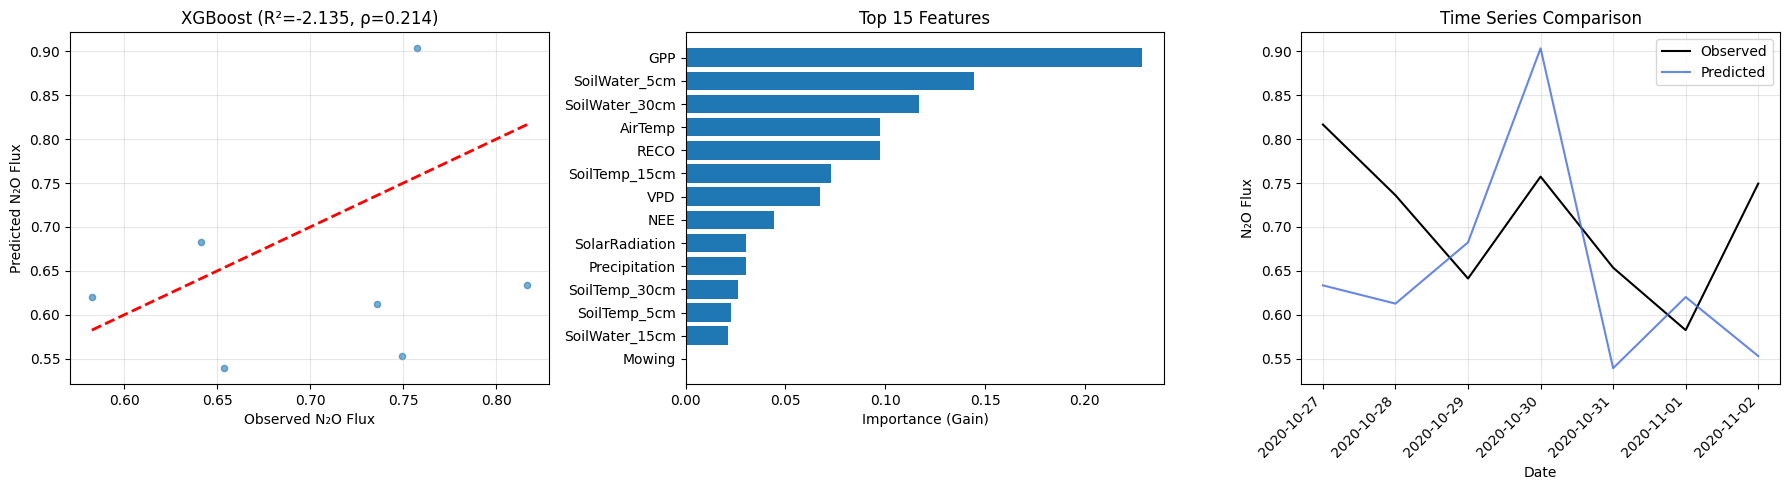


--- DAILY | target=N2O_Flux_ln | predictors=LAG ---
Train period: 2019-07-03 00:00:00 → 2020-10-13 00:00:00
Test  period: 2020-10-14 00:00:00 → 2020-11-02 00:00:00

Model evaluation:
  R² (linear scale): -2.167
  Spearman ρ:        0.143


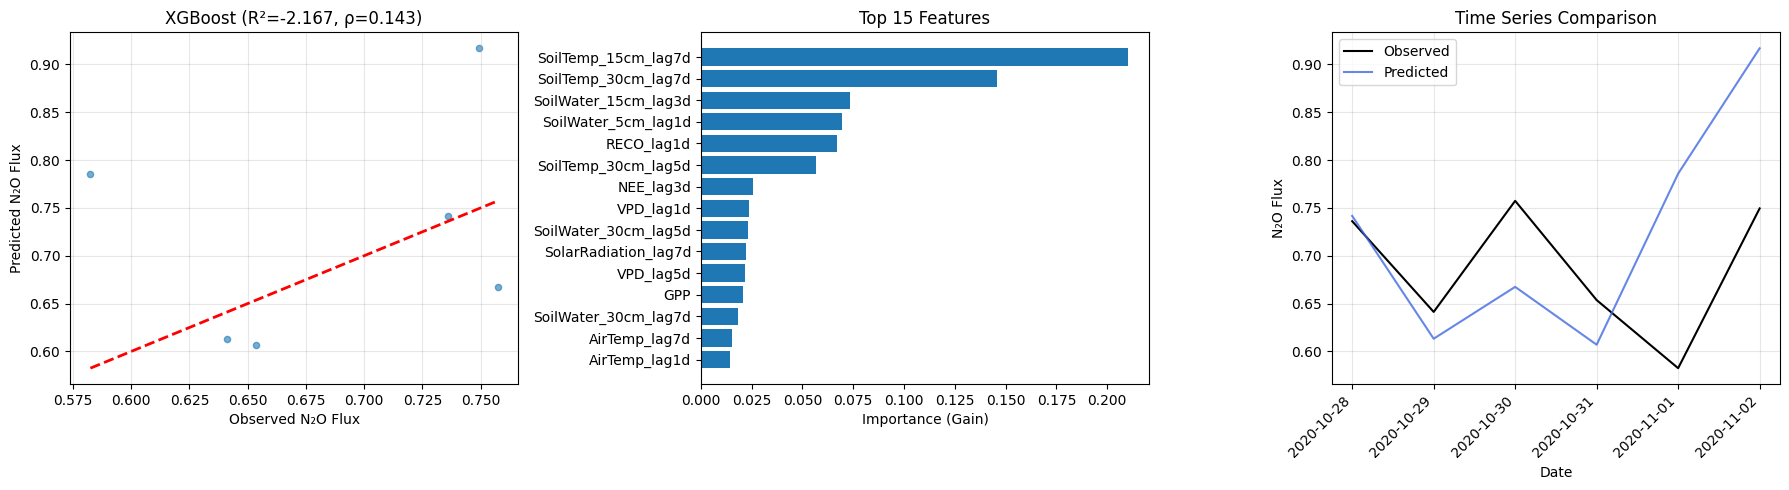


COMPREHENSIVE COMPARISON OF ALL EXPERIMENTS:
Temporal     Predictors   R²       Spearman ρ  
--------------------------------------------------------------------------------
Hourly       Base         -2.066        0.080
Hourly       Lag          -0.434        0.103
Daily        Base         -2.135        0.214
Daily        Lag          -2.167        0.143

IMPROVEMENT FROM BASE TO LAG:
Hourly: R² + 1.632, ρ + 0.023
Daily:  R² +-0.032, ρ +-0.071


In [169]:
# ============================================================================
# AESCHI
# ============================================================================

print("="*80)
print("EXPERIMENT 3: Aeschi 2019-20")
print("="*80)

# Define base and lag predictors
base_predictors = [
    "Precipitation", "SolarRadiation", "AirTemp", "VPD",
    "SoilWater_5cm", "SoilWater_15cm", "SoilWater_30cm",
    "SoilTemp_5cm", "SoilTemp_15cm", "SoilTemp_30cm",
    "NEE", "GPP", "RECO",
    "Mowing"
]

lag_predictors = [
    # --- Meteorological base variables ---
    "Precipitation", "SolarRadiation", "AirTemp", "VPD",
    "SoilWater_5cm", "SoilWater_15cm", "SoilWater_30cm",
    "SoilTemp_5cm", "SoilTemp_15cm", "SoilTemp_30cm",
    "NEE", "GPP", "RECO",

    # --- Meteorological lag variables ---
    "Precipitation_lag1d", "Precipitation_lag3d", "Precipitation_lag5d", "Precipitation_lag7d",
    "SolarRadiation_lag1d", "SolarRadiation_lag3d", "SolarRadiation_lag5d", "SolarRadiation_lag7d",
    "AirTemp_lag1d", "AirTemp_lag3d", "AirTemp_lag5d", "AirTemp_lag7d",
    "VPD_lag1d", "VPD_lag3d", "VPD_lag5d", "VPD_lag7d",
    "SoilWater_5cm_lag1d", "SoilWater_5cm_lag3d", "SoilWater_5cm_lag5d", "SoilWater_5cm_lag7d",
    "SoilWater_15cm_lag1d", "SoilWater_15cm_lag3d", "SoilWater_15cm_lag5d", "SoilWater_15cm_lag7d",
    "SoilWater_30cm_lag1d", "SoilWater_30cm_lag3d", "SoilWater_30cm_lag5d", "SoilWater_30cm_lag7d",
    "SoilTemp_5cm_lag1d", "SoilTemp_5cm_lag3d", "SoilTemp_5cm_lag5d", "SoilTemp_5cm_lag7d",
    "SoilTemp_15cm_lag1d", "SoilTemp_15cm_lag3d", "SoilTemp_15cm_lag5d", "SoilTemp_15cm_lag7d",
    "SoilTemp_30cm_lag1d", "SoilTemp_30cm_lag3d", "SoilTemp_30cm_lag5d", "SoilTemp_30cm_lag7d",
    "NEE_lag1d", "NEE_lag3d", "NEE_lag5d", "NEE_lag7d",
    "GPP_lag1d", "GPP_lag3d", "GPP_lag5d", "GPP_lag7d",
    "RECO_lag1d", "RECO_lag3d", "RECO_lag5d", "RECO_lag7d",

    # --- Management variables ---
    "Mowing"
]

# Store results for comparison
all_results = []

# ============================================================================
# HOURLY DATA - BASE PREDICTORS
# ============================================================================
print("\n" + "="*80)
print("--- HOURLY | target=N2O_Flux_ln | predictors=BASE ---")
print("="*80)

results_hourly_base = train_xgb_timeseries(
    df=aeschi_lag,
    predictors=base_predictors,
    target="N2O_Flux_ln",
    plot=True
)
all_results.append(("Hourly", "Base", results_hourly_base['r2'], results_hourly_base['spearman_rho']))

# ============================================================================
# HOURLY DATA - LAG PREDICTORS
# ============================================================================
print("\n" + "="*80)
print("--- HOURLY | target=N2O_Flux_ln | predictors=LAG ---")
print("="*80)

results_hourly_lag = train_xgb_timeseries(
    df=aeschi_lag,
    predictors=lag_predictors,
    target="N2O_Flux_ln",
    plot=True
)
all_results.append(("Hourly", "Lag", results_hourly_lag['r2'], results_hourly_lag['spearman_rho']))

# ============================================================================
# DAILY DATA - BASE PREDICTORS
# ============================================================================
print("\n" + "="*80)
print("--- DAILY | target=N2O_Flux_ln | predictors=BASE ---")
print("="*80)

results_daily_base = train_xgb_timeseries(
    df=aeschi_daily,
    predictors=base_predictors,
    target="N2O_Flux_ln",
    plot=True
)
all_results.append(("Daily", "Base", results_daily_base['r2'], results_daily_base['spearman_rho']))

# ============================================================================
# DAILY DATA - LAG PREDICTORS
# ============================================================================
print("\n" + "="*80)
print("--- DAILY | target=N2O_Flux_ln | predictors=LAG ---")
print("="*80)

results_daily_lag = train_xgb_timeseries(
    df=aeschi_daily,
    predictors=lag_predictors,
    target="N2O_Flux_ln",
    plot=True
)
all_results.append(("Daily", "Lag", results_daily_lag['r2'], results_daily_lag['spearman_rho']))

# ============================================================================
# COMPREHENSIVE COMPARISON
# ============================================================================
print("\n" + "="*80)
print("COMPREHENSIVE COMPARISON OF ALL EXPERIMENTS:")
print("="*80)
print(f"{'Temporal':<12} {'Predictors':<12} {'R²':<8} {'Spearman ρ':<12}")
print("-"*80)
for temp, pred, r2, rho in all_results:
    print(f"{temp:<12} {pred:<12} {r2:>6.3f}   {rho:>10.3f}")

print("\n" + "="*80)
print("IMPROVEMENT FROM BASE TO LAG:")
print("="*80)
print(f"Hourly: R² +{(results_hourly_lag['r2'] - results_hourly_base['r2']):>6.3f}, ρ +{(results_hourly_lag['spearman_rho'] - results_hourly_base['spearman_rho']):>6.3f}")
print(f"Daily:  R² +{(results_daily_lag['r2'] - results_daily_base['r2']):>6.3f}, ρ +{(results_daily_lag['spearman_rho'] - results_daily_base['spearman_rho']):>6.3f}")

# Experiment 4: Chamau dataset

In [43]:
# FIX TIMESTAMP
chamau_lag['Timestamp'] = pd.to_datetime(chamau_lag['Timestamp'])
chamau_lag = chamau_lag.set_index('Timestamp').sort_index()

chamau_daily['Date'] = pd.to_datetime(chamau_daily['Date'])
chamau_daily = chamau_daily.sort_values('Date')

# SPLIT BY PARCEL
chamau_A = chamau_lag[chamau_lag['Parcel'] == 'A'].copy()
chamau_B = chamau_lag[chamau_lag['Parcel'] == 'B'].copy()
chamau_daily_A = chamau_daily[chamau_daily['Parcel'] == 'A'].set_index('Date')
chamau_daily_B = chamau_daily[chamau_daily['Parcel'] == 'B'].set_index('Date')

# PREDICTOR SETS
predictor_sets = {
    "base": [
        "Precipitation", "SolarRadiation", "AirTemp", "VPD",
        "SoilWater_5cm", "SoilWater_15cm", "SoilTemp_4cm", "SoilTemp_15cm",
        "NEE", "GPP", "RECO",
        "Mowing", "FertilizerOrganic", "FertilizerMineral", "Grazing", "SoilCultivation"
    ],
    
    "lag": [
        "Precipitation", "SolarRadiation", "AirTemp", "VPD",
        "SoilWater_5cm", "SoilWater_15cm", "SoilTemp_4cm", "SoilTemp_15cm",
        "NEE", "GPP", "RECO",
        "NEE_lag1d_daily", "NEE_lag3d_daily", "NEE_lag5d_daily", "NEE_lag7d_daily",
        "GPP_lag1d_daily", "GPP_lag3d_daily", "GPP_lag5d_daily", "GPP_lag7d_daily",
        "RECO_lag1d_daily", "RECO_lag3d_daily", "RECO_lag5d_daily", "RECO_lag7d_daily",
        "SolarRadiation_lag1d_daily", "SolarRadiation_lag3d_daily", "SolarRadiation_lag5d_daily", "SolarRadiation_lag7d_daily",
        "AirTemp_lag1d_daily", "AirTemp_lag3d_daily", "AirTemp_lag5d_daily", "AirTemp_lag7d_daily",
        "VPD_lag1d_daily", "VPD_lag3d_daily", "VPD_lag5d_daily", "VPD_lag7d_daily",
        "SoilWater_5cm_lag1d_daily", "SoilWater_5cm_lag3d_daily", "SoilWater_5cm_lag5d_daily", "SoilWater_5cm_lag7d_daily",
        "SoilWater_15cm_lag1d_daily", "SoilWater_15cm_lag3d_daily", "SoilWater_15cm_lag5d_daily", "SoilWater_15cm_lag7d_daily",
        "SoilTemp_4cm_lag1d_daily", "SoilTemp_4cm_lag3d_daily", "SoilTemp_4cm_lag5d_daily", "SoilTemp_4cm_lag7d_daily",
        "SoilTemp_15cm_lag1d_daily", "SoilTemp_15cm_lag3d_daily", "SoilTemp_15cm_lag5d_daily", "SoilTemp_15cm_lag7d_daily",
        "Precipitation_lag1d_daily", "Precipitation_lag3d_daily", "Precipitation_lag5d_daily", "Precipitation_lag7d_daily",
        "Mowing", "FertilizerOrganic", "FertilizerMineral", "Grazing", "SoilCultivation",
        "DaysSince_Mowing", "DaysSince_FertilizerOrganic", "DaysSince_FertilizerMineral",
        "DaysSince_Grazing", "DaysSince_SoilCultivation"
    ],
    
    "augmented": [
        # Base current-day variables
        "Precipitation", "SolarRadiation", "AirTemp", "VPD",
        "SoilWater_5cm", "SoilWater_15cm", "SoilTemp_4cm", "SoilTemp_15cm",
        "NEE", "GPP", "RECO",
        
        # Lag features (1, 3, 5, 7 days)
        "NEE_lag1d_daily", "NEE_lag3d_daily", "NEE_lag5d_daily", "NEE_lag7d_daily",
        "GPP_lag1d_daily", "GPP_lag3d_daily", "GPP_lag5d_daily", "GPP_lag7d_daily",
        "RECO_lag1d_daily", "RECO_lag3d_daily", "RECO_lag5d_daily", "RECO_lag7d_daily",
        "SolarRadiation_lag1d_daily", "SolarRadiation_lag3d_daily", "SolarRadiation_lag5d_daily", "SolarRadiation_lag7d_daily",
        "AirTemp_lag1d_daily", "AirTemp_lag3d_daily", "AirTemp_lag5d_daily", "AirTemp_lag7d_daily",
        "VPD_lag1d_daily", "VPD_lag3d_daily", "VPD_lag5d_daily", "VPD_lag7d_daily",
        "SoilWater_5cm_lag1d_daily", "SoilWater_5cm_lag3d_daily", "SoilWater_5cm_lag5d_daily", "SoilWater_5cm_lag7d_daily",
        "SoilWater_15cm_lag1d_daily", "SoilWater_15cm_lag3d_daily", "SoilWater_15cm_lag5d_daily", "SoilWater_15cm_lag7d_daily",
        "SoilTemp_4cm_lag1d_daily", "SoilTemp_4cm_lag3d_daily", "SoilTemp_4cm_lag5d_daily", "SoilTemp_4cm_lag7d_daily",
        "SoilTemp_15cm_lag1d_daily", "SoilTemp_15cm_lag3d_daily", "SoilTemp_15cm_lag5d_daily", "SoilTemp_15cm_lag7d_daily",
        "Precipitation_lag1d_daily", "Precipitation_lag3d_daily", "Precipitation_lag5d_daily", "Precipitation_lag7d_daily",
        
        # Rolling mean features (3, 5, 7 day windows)
        "NEE_roll3d_mean", "NEE_roll5d_mean", "NEE_roll7d_mean",
        "GPP_roll3d_mean", "GPP_roll5d_mean", "GPP_roll7d_mean",
        "RECO_roll3d_mean", "RECO_roll5d_mean", "RECO_roll7d_mean",
        "SolarRadiation_roll3d_mean", "SolarRadiation_roll5d_mean", "SolarRadiation_roll7d_mean",
        "AirTemp_roll3d_mean", "AirTemp_roll5d_mean", "AirTemp_roll7d_mean",
        "VPD_roll3d_mean", "VPD_roll5d_mean", "VPD_roll7d_mean",
        "SoilWater_5cm_roll3d_mean", "SoilWater_5cm_roll5d_mean", "SoilWater_5cm_roll7d_mean",
        "SoilWater_15cm_roll3d_mean", "SoilWater_15cm_roll5d_mean", "SoilWater_15cm_roll7d_mean",
        "SoilTemp_4cm_roll3d_mean", "SoilTemp_4cm_roll5d_mean", "SoilTemp_4cm_roll7d_mean",
        "SoilTemp_15cm_roll3d_mean", "SoilTemp_15cm_roll5d_mean", "SoilTemp_15cm_roll7d_mean",
        "Precipitation_roll3d_mean", "Precipitation_roll5d_mean", "Precipitation_roll7d_mean",
        
        # Rolling sum features (3, 5, 7 day windows)
        "NEE_roll3d_sum", "NEE_roll5d_sum", "NEE_roll7d_sum",
        "GPP_roll3d_sum", "GPP_roll5d_sum", "GPP_roll7d_sum",
        "RECO_roll3d_sum", "RECO_roll5d_sum", "RECO_roll7d_sum",
        "SolarRadiation_roll3d_sum", "SolarRadiation_roll5d_sum", "SolarRadiation_roll7d_sum",
        "AirTemp_roll3d_sum", "AirTemp_roll5d_sum", "AirTemp_roll7d_sum",
        "VPD_roll3d_sum", "VPD_roll5d_sum", "VPD_roll7d_sum",
        "SoilWater_5cm_roll3d_sum", "SoilWater_5cm_roll5d_sum", "SoilWater_5cm_roll7d_sum",
        "SoilWater_15cm_roll3d_sum", "SoilWater_15cm_roll5d_sum", "SoilWater_15cm_roll7d_sum",
        "SoilTemp_4cm_roll3d_sum", "SoilTemp_4cm_roll5d_sum", "SoilTemp_4cm_roll7d_sum",
        "SoilTemp_15cm_roll3d_sum", "SoilTemp_15cm_roll5d_sum", "SoilTemp_15cm_roll7d_sum",
        "Precipitation_roll3d_sum", "Precipitation_roll5d_sum", "Precipitation_roll7d_sum",
        
        # Management events and days since
        "Mowing", "FertilizerOrganic", "FertilizerMineral", "Grazing", "SoilCultivation",
        "DaysSince_Mowing", "DaysSince_FertilizerOrganic", "DaysSince_FertilizerMineral",
        "DaysSince_Grazing", "DaysSince_SoilCultivation"
    ],
    
    "main": ["AirTemp", "VPD", "SoilTemp_4cm", "SoilTemp_15cm", "RECO", "SolarRadiation"]
}

# DATASETS
datasets = {
    "Hourly": chamau_lag,
    "Hourly A": chamau_A,
    "Hourly B": chamau_B,
    "Daily A": chamau_daily_A,
    "Daily B": chamau_daily_B,
    "Daily": chamau_daily
}

targets = ["N2O_Flux", "N2O_Flux_ln"]

In [44]:
def train_xgb_timeseries(df, predictors, target, test_size=0.1, n_estimators=300, random_state=42, plot=True):
    """
    Train XGBoost on time-series data using chronological split.
    
    Now includes a time series comparison plot showing observed vs predicted values over time.
    """
    # ENSURE TIME ORDER
    df = df.sort_index().copy()
    
    # EXTRACT FEATURES/TARGET
    X = df[predictors]
    y = df[target]
    
    # HANDLE NaNs
    mask = X.notna().all(axis=1) & y.notna()
    X, y = X[mask], y[mask]
    
    # OFFSET FOR POSITIVITY
    offset = abs(y.min()) + 1e-6
    y_shifted = y + offset
    
    # CHRONOLOGICAL SPLIT
    split_idx = int(len(X) * (1 - test_size))
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y_shifted.iloc[:split_idx], y_shifted.iloc[split_idx:]
    
    # Store test dates for time series plot
    test_dates = X_test.index
    
    time_train = (df.index.min(), df.index[:split_idx].max())
    time_test = (df.index[split_idx], df.index.max())
    
    print(f"Train period: {time_train[0]} → {time_train[1]}")
    print(f"Test  period: {time_test[0]} → {time_test[1]}")
    
    # TRAIN MODEL
    model = XGBRegressor(
        n_estimators=n_estimators,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=random_state,
        n_jobs=-1
    )
    model.fit(X_train, y_train, verbose=False)
    
    # PREDICTIONS
    y_pred = model.predict(X_test)
    
    # REVERT OFFSET
    y_pred_lin = y_pred - offset
    y_test_lin = y_test - offset
    
    # EVALUATION
    r2 = r2_score(y_test_lin, y_pred_lin)
    rho, _ = spearmanr(y_test_lin, y_pred_lin)
    
    # FEATURE IMPORTANCE
    importances = pd.Series(model.feature_importances_, index=predictors).sort_values(ascending=False)
    
    print("\nModel evaluation:")
    print(f"  R² (linear scale): {r2:.3f}")
    print(f"  Spearman ρ:        {rho:.3f}")
    
    # PLOT
    if plot:
        # Create 3-subplot figure: scatter, feature importance, and TIME SERIES
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))
        
        # 1. Scatter plot
        axes[0].scatter(y_test_lin, y_pred_lin, alpha=0.6, s=20)
        min_val, max_val = y_test_lin.min(), y_test_lin.max()
        axes[0].plot([min_val, max_val], [min_val, max_val], "r--", lw=2)
        axes[0].set_xlabel("Observed N₂O Flux")
        axes[0].set_ylabel("Predicted N₂O Flux")
        axes[0].set_title(f"XGBoost (R²={r2:.3f}, ρ={rho:.3f})")
        axes[0].grid(True, alpha=0.3)
        
        # 2. Feature importance
        top_features = importances.head(15)
        axes[1].barh(range(len(top_features)), top_features.values)
        axes[1].set_yticks(range(len(top_features)))
        axes[1].set_yticklabels(top_features.index)
        axes[1].set_xlabel("Importance (Gain)")
        axes[1].set_title("Top 15 Features")
        axes[1].invert_yaxis()
        
        # 3. TIME SERIES COMPARISON (NEW!)
        axes[2].plot(test_dates, y_test_lin.values, label="Observed", color="black", lw=1.5)
        axes[2].plot(test_dates, y_pred_lin, label="Predicted", color="royalblue", lw=1.5, alpha=0.8)
        axes[2].set_xlabel("Date")
        axes[2].set_ylabel("N₂O Flux")
        axes[2].set_title("Time Series Comparison")
        axes[2].legend()
        axes[2].grid(True, alpha=0.3)
        
        # Rotate x-axis labels for better readability
        plt.setp(axes[2].xaxis.get_majorticklabels(), rotation=45, ha='right')
        
        plt.tight_layout()
        plt.show()
    
    return {
        "model": model,
        "r2": r2,
        "spearman_rho": rho,
        "feature_importance": importances,
        "y_test": y_test_lin,
        "y_pred": y_pred_lin,
        "test_dates": test_dates,  # Also return test dates
    }

EXPERIMENT 4: Chamau 2014-2024

--- HOURLY | target=N2O_Flux_ln | predictors=BASE ---
Train period: 2014-01-01 08:15:00 → 2021-07-31 12:15:00
Test  period: 2021-07-31 13:15:00 → 2022-07-06 09:15:00

Model evaluation:
  R² (linear scale): 0.145
  Spearman ρ:        0.321


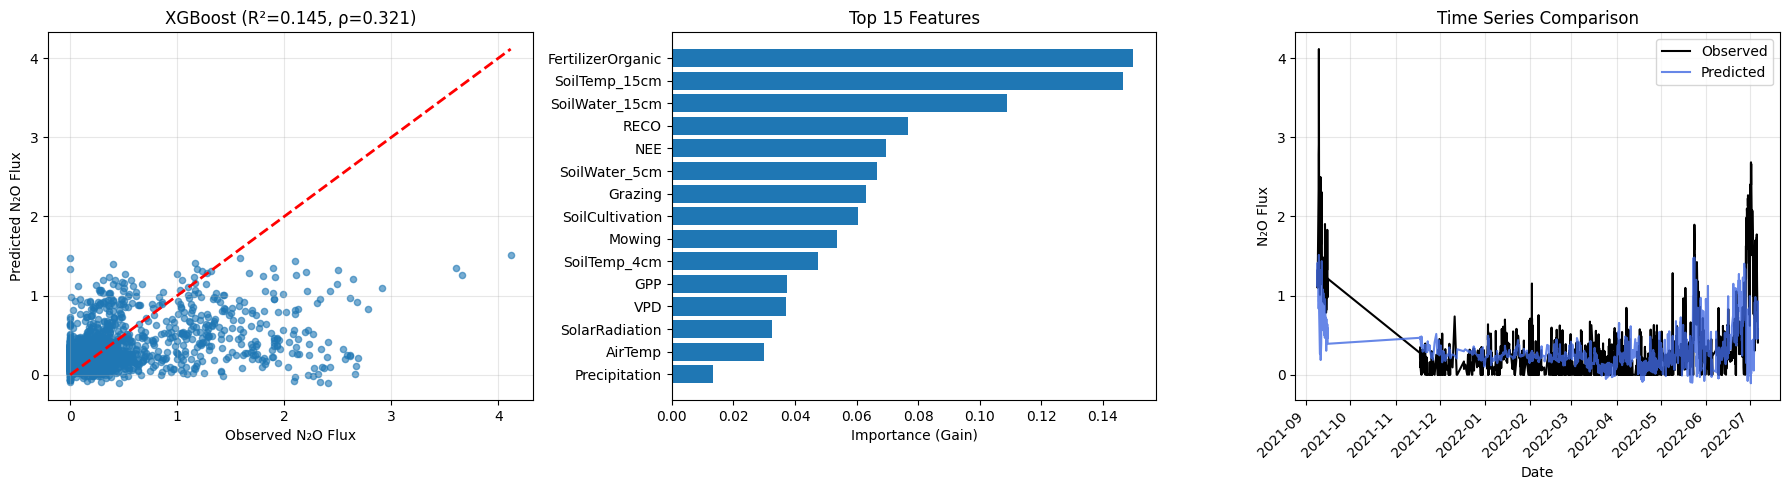


--- DAILY | target=N2O_Flux_ln | predictors=BASE ---
Train period: 0 → 3689
Test  period: 3690 → 4338

Model evaluation:
  R² (linear scale): 0.762
  Spearman ρ:        0.582


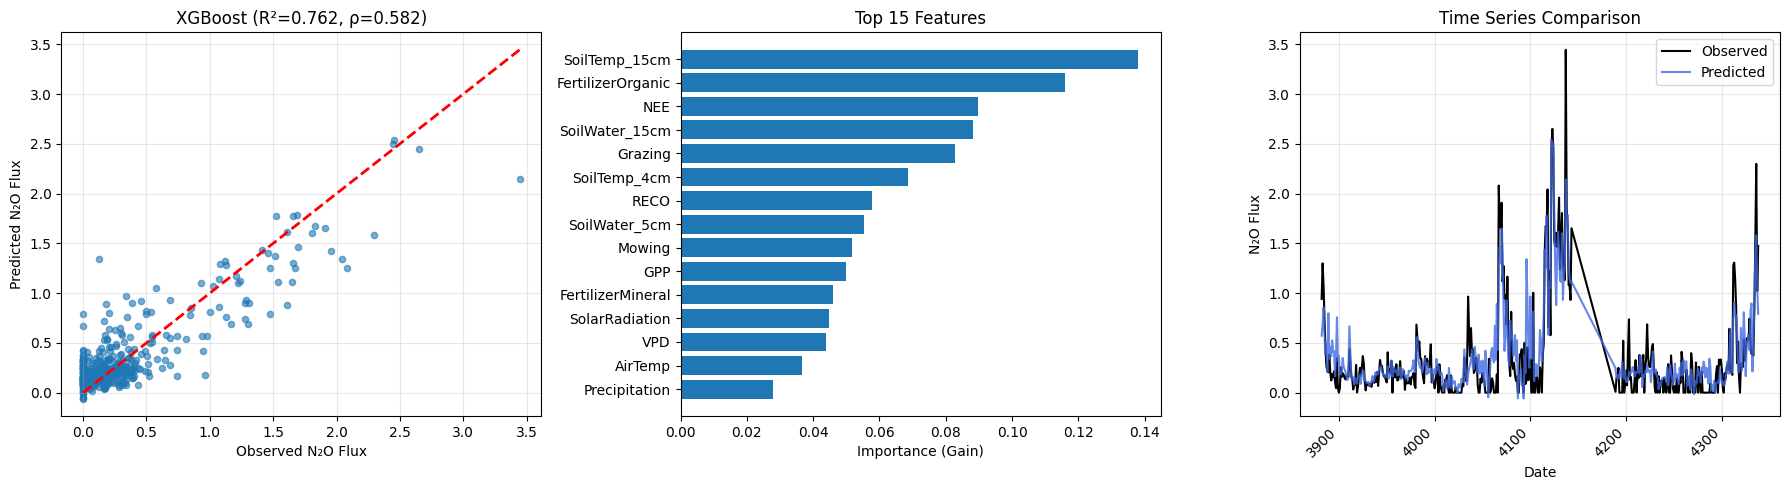


--- DAILY | target=N2O_Flux_ln | predictors=LAG ---
Train period: 0 → 3642
Test  period: 3643 → 4338

Model evaluation:
  R² (linear scale): 0.831
  Spearman ρ:        0.626


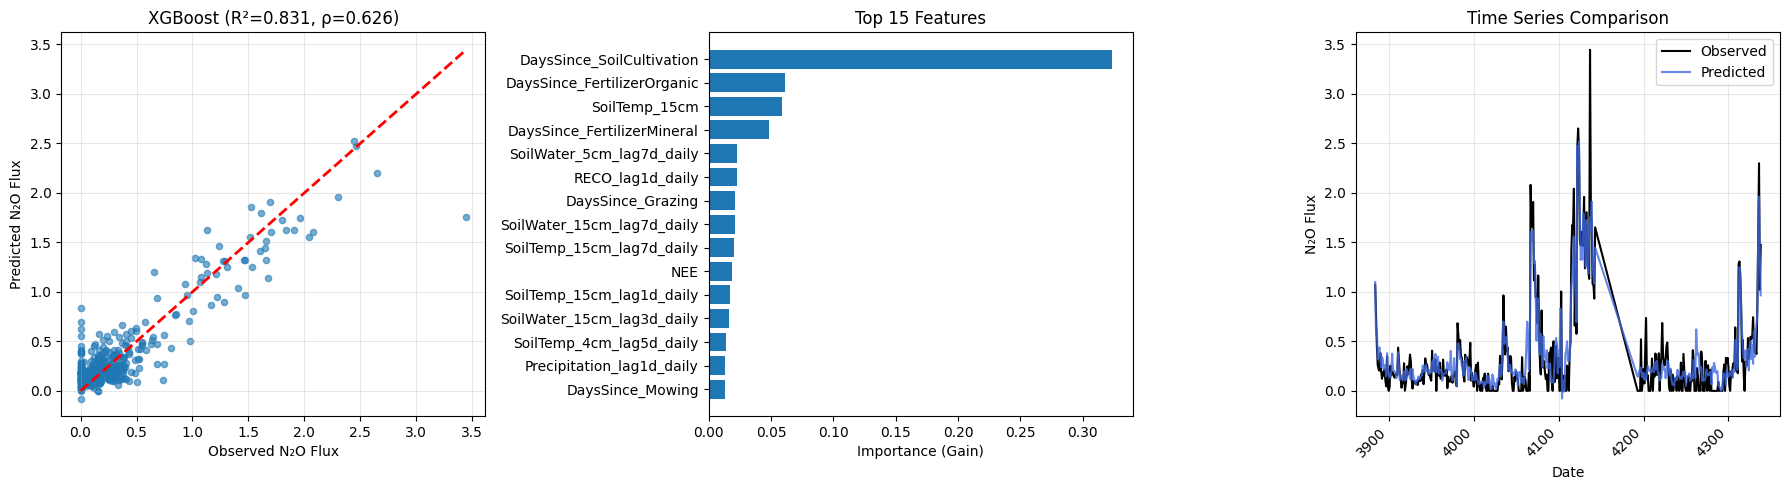


--- DAILY | target=N2O_Flux_ln | predictors=AUGMENTED ---
Train period: 0 → 3642
Test  period: 3643 → 4338

Model evaluation:
  R² (linear scale): 0.799
  Spearman ρ:        0.605


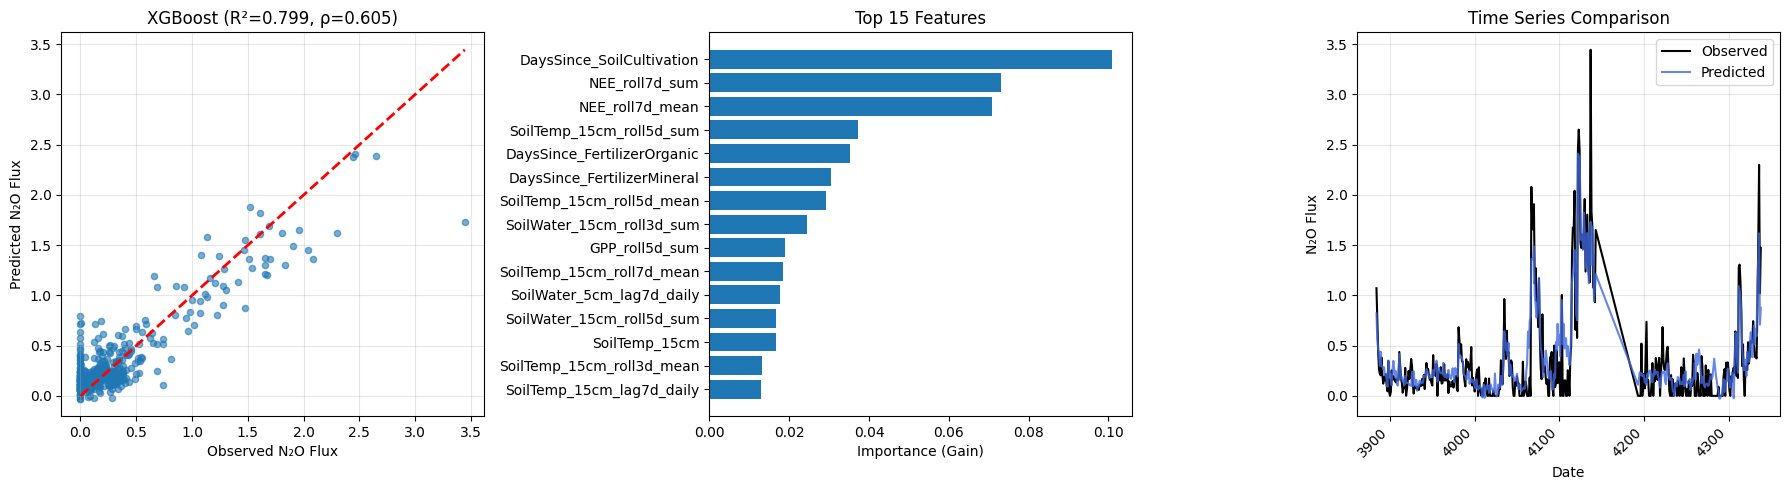


COMPREHENSIVE COMPARISON OF ALL EXPERIMENTS:
Temporal     Predictors   R²       Spearman ρ  
--------------------------------------------------------------------------------
Hourly       Base          0.145        0.321
Daily        Base          0.762        0.582
Daily        Lag           0.831        0.626
Daily        Augmented     0.799        0.605

IMPROVEMENT FROM BASE TO LAG:
Hourly: R² + 0.189, ρ + 0.300
Daily:  R² + 0.037, ρ + 0.023


In [46]:
# ============================================================================
# CHAMAU
# ============================================================================

print("="*80)
print("EXPERIMENT 4: Chamau 2014-2024")
print("="*80)

# Define base and lag predictors
base_predictors = [
    "Precipitation", "SolarRadiation", "AirTemp", "VPD",
    "SoilWater_5cm", "SoilWater_15cm",
    "SoilTemp_4cm", "SoilTemp_15cm",
    "NEE", "GPP", "RECO",
    "Mowing", "FertilizerOrganic", "FertilizerMineral", "Grazing", "SoilCultivation"
]

lag_predictors = [
    # --- Meteorological base variables ---
    "Precipitation", "SolarRadiation", "AirTemp", "VPD",
    "SoilWater_5cm", "SoilWater_15cm",
    "SoilTemp_4cm", "SoilTemp_15cm",
    "NEE", "GPP", "RECO",

    # --- Meteorological lag variables ---
    "NEE_lag1d_daily", "NEE_lag3d_daily", "NEE_lag5d_daily", "NEE_lag7d_daily",
    "GPP_lag1d_daily", "GPP_lag3d_daily", "GPP_lag5d_daily", "GPP_lag7d_daily",
    "RECO_lag1d_daily", "RECO_lag3d_daily", "RECO_lag5d_daily", "RECO_lag7d_daily",
    "SolarRadiation_lag1d_daily", "SolarRadiation_lag3d_daily", "SolarRadiation_lag5d_daily", "SolarRadiation_lag7d_daily",
    "AirTemp_lag1d_daily", "AirTemp_lag3d_daily", "AirTemp_lag5d_daily", "AirTemp_lag7d_daily",
    "VPD_lag1d_daily", "VPD_lag3d_daily", "VPD_lag5d_daily", "VPD_lag7d_daily",
    "SoilWater_5cm_lag1d_daily", "SoilWater_5cm_lag3d_daily", "SoilWater_5cm_lag5d_daily", "SoilWater_5cm_lag7d_daily",
    "SoilWater_15cm_lag1d_daily", "SoilWater_15cm_lag3d_daily", "SoilWater_15cm_lag5d_daily", "SoilWater_15cm_lag7d_daily",
    "SoilTemp_4cm_lag1d_daily", "SoilTemp_4cm_lag3d_daily", "SoilTemp_4cm_lag5d_daily", "SoilTemp_4cm_lag7d_daily",
    "SoilTemp_15cm_lag1d_daily", "SoilTemp_15cm_lag3d_daily", "SoilTemp_15cm_lag5d_daily", "SoilTemp_15cm_lag7d_daily",
    "Precipitation_lag1d_daily", "Precipitation_lag3d_daily", "Precipitation_lag5d_daily", "Precipitation_lag7d_daily",

    # --- Management variables ---
    "Mowing", "FertilizerOrganic", "FertilizerMineral", "Grazing", "SoilCultivation",
    "DaysSince_Mowing", "DaysSince_FertilizerOrganic", "DaysSince_FertilizerMineral",
    "DaysSince_Grazing", "DaysSince_SoilCultivation"
]

augmented_predictors = [
    # --- Base current-day variables ---
    "Precipitation", "SolarRadiation", "AirTemp", "VPD",
    "SoilWater_5cm", "SoilWater_15cm", "SoilTemp_4cm", "SoilTemp_15cm",
    "NEE", "GPP", "RECO",
    
    # --- Lag features (1, 3, 5, 7 days) ---
    "NEE_lag1d_daily", "NEE_lag3d_daily", "NEE_lag5d_daily", "NEE_lag7d_daily",
    "GPP_lag1d_daily", "GPP_lag3d_daily", "GPP_lag5d_daily", "GPP_lag7d_daily",
    "RECO_lag1d_daily", "RECO_lag3d_daily", "RECO_lag5d_daily", "RECO_lag7d_daily",
    "SolarRadiation_lag1d_daily", "SolarRadiation_lag3d_daily", "SolarRadiation_lag5d_daily", "SolarRadiation_lag7d_daily",
    "AirTemp_lag1d_daily", "AirTemp_lag3d_daily", "AirTemp_lag5d_daily", "AirTemp_lag7d_daily",
    "VPD_lag1d_daily", "VPD_lag3d_daily", "VPD_lag5d_daily", "VPD_lag7d_daily",
    "SoilWater_5cm_lag1d_daily", "SoilWater_5cm_lag3d_daily", "SoilWater_5cm_lag5d_daily", "SoilWater_5cm_lag7d_daily",
    "SoilWater_15cm_lag1d_daily", "SoilWater_15cm_lag3d_daily", "SoilWater_15cm_lag5d_daily", "SoilWater_15cm_lag7d_daily",
    "SoilTemp_4cm_lag1d_daily", "SoilTemp_4cm_lag3d_daily", "SoilTemp_4cm_lag5d_daily", "SoilTemp_4cm_lag7d_daily",
    "SoilTemp_15cm_lag1d_daily", "SoilTemp_15cm_lag3d_daily", "SoilTemp_15cm_lag5d_daily", "SoilTemp_15cm_lag7d_daily",
    "Precipitation_lag1d_daily", "Precipitation_lag3d_daily", "Precipitation_lag5d_daily", "Precipitation_lag7d_daily",
    
    # --- Rolling mean features (3, 5, 7 day windows) ---
    "NEE_roll3d_mean", "NEE_roll5d_mean", "NEE_roll7d_mean",
    "GPP_roll3d_mean", "GPP_roll5d_mean", "GPP_roll7d_mean",
    "RECO_roll3d_mean", "RECO_roll5d_mean", "RECO_roll7d_mean",
    "SolarRadiation_roll3d_mean", "SolarRadiation_roll5d_mean", "SolarRadiation_roll7d_mean",
    "AirTemp_roll3d_mean", "AirTemp_roll5d_mean", "AirTemp_roll7d_mean",
    "VPD_roll3d_mean", "VPD_roll5d_mean", "VPD_roll7d_mean",
    "SoilWater_5cm_roll3d_mean", "SoilWater_5cm_roll5d_mean", "SoilWater_5cm_roll7d_mean",
    "SoilWater_15cm_roll3d_mean", "SoilWater_15cm_roll5d_mean", "SoilWater_15cm_roll7d_mean",
    "SoilTemp_4cm_roll3d_mean", "SoilTemp_4cm_roll5d_mean", "SoilTemp_4cm_roll7d_mean",
    "SoilTemp_15cm_roll3d_mean", "SoilTemp_15cm_roll5d_mean", "SoilTemp_15cm_roll7d_mean",
    "Precipitation_roll3d_mean", "Precipitation_roll5d_mean", "Precipitation_roll7d_mean",
    
    # --- Rolling sum features (3, 5, 7 day windows) ---
    "NEE_roll3d_sum", "NEE_roll5d_sum", "NEE_roll7d_sum",
    "GPP_roll3d_sum", "GPP_roll5d_sum", "GPP_roll7d_sum",
    "RECO_roll3d_sum", "RECO_roll5d_sum", "RECO_roll7d_sum",
    "SolarRadiation_roll3d_sum", "SolarRadiation_roll5d_sum", "SolarRadiation_roll7d_sum",
    "AirTemp_roll3d_sum", "AirTemp_roll5d_sum", "AirTemp_roll7d_sum",
    "VPD_roll3d_sum", "VPD_roll5d_sum", "VPD_roll7d_sum",
    "SoilWater_5cm_roll3d_sum", "SoilWater_5cm_roll5d_sum", "SoilWater_5cm_roll7d_sum",
    "SoilWater_15cm_roll3d_sum", "SoilWater_15cm_roll5d_sum", "SoilWater_15cm_roll7d_sum",
    "SoilTemp_4cm_roll3d_sum", "SoilTemp_4cm_roll5d_sum", "SoilTemp_4cm_roll7d_sum",
    "SoilTemp_15cm_roll3d_sum", "SoilTemp_15cm_roll5d_sum", "SoilTemp_15cm_roll7d_sum",
    "Precipitation_roll3d_sum", "Precipitation_roll5d_sum", "Precipitation_roll7d_sum",
    
    # --- Management variables ---
    "Mowing", "FertilizerOrganic", "FertilizerMineral", "Grazing", "SoilCultivation",
    "DaysSince_Mowing", "DaysSince_FertilizerOrganic", "DaysSince_FertilizerMineral",
    "DaysSince_Grazing", "DaysSince_SoilCultivation"
]

# Store results for comparison
all_results = []

# ============================================================================
# HOURLY DATA - BASE PREDICTORS
# ============================================================================
print("\n" + "="*80)
print("--- HOURLY | target=N2O_Flux_ln | predictors=BASE ---")
print("="*80)

results_hourly_base = train_xgb_timeseries(
    df=chamau_lag,
    predictors=base_predictors,
    target="N2O_Flux_ln",
    plot=True
)
all_results.append(("Hourly", "Base", results_hourly_base['r2'], results_hourly_base['spearman_rho']))

# ============================================================================
# DAILY DATA - BASE PREDICTORS
# ============================================================================
print("\n" + "="*80)
print("--- DAILY | target=N2O_Flux_ln | predictors=BASE ---")
print("="*80)

results_daily_base = train_xgb_timeseries(
    df=chamau_daily,
    predictors=base_predictors,
    target="N2O_Flux_ln",
    plot=True
)
all_results.append(("Daily", "Base", results_daily_base['r2'], results_daily_base['spearman_rho']))

# ============================================================================
# DAILY DATA - LAG PREDICTORS
# ============================================================================
print("\n" + "="*80)
print("--- DAILY | target=N2O_Flux_ln | predictors=LAG ---")
print("="*80)

results_daily_lag = train_xgb_timeseries(
    df=chamau_daily,
    predictors=lag_predictors,
    target="N2O_Flux_ln",
    plot=True
)
all_results.append(("Daily", "Lag", results_daily_lag['r2'], results_daily_lag['spearman_rho']))


# ============================================================================
# DAILY DATA - AUGMENTED PREDICTORS
# ============================================================================
print("\n" + "="*80)
print("--- DAILY | target=N2O_Flux_ln | predictors=AUGMENTED ---")
print("="*80)

results_daily_lag = train_xgb_timeseries(
    df=chamau_daily,
    predictors=augmented_predictors,
    target="N2O_Flux_ln",
    plot=True
)
all_results.append(("Daily", "Augmented", results_daily_lag['r2'], results_daily_lag['spearman_rho']))

# ============================================================================
# COMPREHENSIVE COMPARISON
# ============================================================================
print("\n" + "="*80)
print("COMPREHENSIVE COMPARISON OF ALL EXPERIMENTS:")
print("="*80)
print(f"{'Temporal':<12} {'Predictors':<12} {'R²':<8} {'Spearman ρ':<12}")
print("-"*80)
for temp, pred, r2, rho in all_results:
    print(f"{temp:<12} {pred:<12} {r2:>6.3f}   {rho:>10.3f}")

print("\n" + "="*80)
print("IMPROVEMENT FROM BASE TO LAG:")
print("="*80)
print(f"Hourly: R² +{(results_hourly_lag['r2'] - results_hourly_base['r2']):>6.3f}, ρ +{(results_hourly_lag['spearman_rho'] - results_hourly_base['spearman_rho']):>6.3f}")
print(f"Daily:  R² +{(results_daily_lag['r2'] - results_daily_base['r2']):>6.3f}, ρ +{(results_daily_lag['spearman_rho'] - results_daily_base['spearman_rho']):>6.3f}")

In [17]:
chamau_daily.head(4)

,Parcel,Date,N2O_Flux,NEE,GPP,RECO,SolarRadiation,AirTemp,VPD,SoilWater_5cm,SoilWater_15cm,SoilTemp_4cm,SoilTemp_15cm,Precipitation,Mowing,FertilizerOrganic,FertilizerMineral,Grazing,SoilCultivation,DaysSince_Mowing,DaysSince_FertilizerOrganic,DaysSince_FertilizerMineral,DaysSince_Grazing,DaysSince_SoilCultivation,WD,NEE_lag1d,NEE_lag3d,NEE_lag5d,NEE_lag7d,GPP_lag1d,GPP_lag3d,GPP_lag5d,GPP_lag7d,RECO_lag1d,RECO_lag3d,RECO_lag5d,RECO_lag7d,SolarRadiation_lag1d,SolarRadiation_lag3d,SolarRadiation_lag5d,SolarRadiation_lag7d,AirTemp_lag1d,AirTemp_lag3d,AirTemp_lag5d,AirTemp_lag7d,VPD_lag1d,VPD_lag3d,VPD_lag5d,VPD_lag7d,SoilWater_5cm_lag1d,SoilWater_5cm_lag3d,SoilWater_5cm_lag5d,SoilWater_5cm_lag7d,SoilWater_15cm_lag1d,SoilWater_15cm_lag3d,SoilWater_15cm_lag5d,SoilWater_15cm_lag7d,SoilTemp_4cm_lag1d,SoilTemp_4cm_lag3d,SoilTemp_4cm_lag5d,SoilTemp_4cm_lag7d,SoilTemp_15cm_lag1d,SoilTemp_15cm_lag3d,SoilTemp_15cm_lag5d,SoilTemp_15cm_lag7d,Precipitation_lag1d,Precipitation_lag3d,Precipitation_lag5d,Precipitation_lag7d,NEE_roll3d_mean,NEE_roll3d_sum,NEE_roll5d_mean,NEE_roll5d_sum,NEE_roll7d_mean,NEE_roll7d_sum,GPP_roll3d_mean,GPP_roll3d_sum,GPP_roll5d_mean,GPP_roll5d_sum,GPP_roll7d_mean,GPP_roll7d_sum,RECO_roll3d_mean,RECO_roll3d_sum,RECO_roll5d_mean,RECO_roll5d_sum,RECO_roll7d_mean,RECO_roll7d_sum,SolarRadiation_roll3d_mean,SolarRadiation_roll3d_sum,SolarRadiation_roll5d_mean,SolarRadiation_roll5d_sum,SolarRadiation_roll7d_mean,SolarRadiation_roll7d_sum,AirTemp_roll3d_mean,AirTemp_roll3d_sum,AirTemp_roll5d_mean,AirTemp_roll5d_sum,AirTemp_roll7d_mean,AirTemp_roll7d_sum,VPD_roll3d_mean,VPD_roll3d_sum,VPD_roll5d_mean,VPD_roll5d_sum,VPD_roll7d_mean,VPD_roll7d_sum,SoilWater_5cm_roll3d_mean,SoilWater_5cm_roll3d_sum,SoilWater_5cm_roll5d_mean,SoilWater_5cm_roll5d_sum,SoilWater_5cm_roll7d_mean,SoilWater_5cm_roll7d_sum,SoilWater_15cm_roll3d_mean,SoilWater_15cm_roll3d_sum,SoilWater_15cm_roll5d_mean,SoilWater_15cm_roll5d_sum,SoilWater_15cm_roll7d_mean,SoilWater_15cm_roll7d_sum,SoilTemp_4cm_roll3d_mean,SoilTemp_4cm_roll3d_sum,SoilTemp_4cm_roll5d_mean,SoilTemp_4cm_roll5d_sum,SoilTemp_4cm_roll7d_mean,SoilTemp_4cm_roll7d_sum,SoilTemp_15cm_roll3d_mean,SoilTemp_15cm_roll3d_sum,SoilTemp_15cm_roll5d_mean,SoilTemp_15cm_roll5d_sum,SoilTemp_15cm_roll7d_mean,SoilTemp_15cm_roll7d_sum,Precipitation_roll3d_mean,Precipitation_roll3d_sum,Precipitation_roll5d_mean,Precipitation_roll5d_sum,Precipitation_roll7d_mean,Precipitation_roll7d_sum,year,month,N2O_Flux_ln,Fertilizer_N_kg_ha,Fertilizer_N_kg_ha_expHL3d,Fertilizer_N_kg_ha_expHL7d,Fertilizer_N_kg_ha_expHL14d
0,A,2014-01-01,0.113504,-0.431513,1.855290,1.423777,57.185453,-0.038861,0.030485,58.517817,47.376410,1.706039,2.582958,0.1317,0.0,0.0,0.0,0.0,0.0,30.0,30.0,30.0,30.000000,30.0,154.745237,-0.185901,-1.179539,0.885267,1.075549,1.468249,2.476004,0.265522,0.088402,1.282348,1.296464,1.150789,1.163950,29.894050,68.640794,3.717586,2.109514,-1.873985,2.290582,-1.027617,0.666818,0.000971,0.028887,0.000185,0.000098,58.757350,59.206821,59.213039,58.268536,47.525087,47.877036,47.893804,47.259720,2.130320,2.808879,2.858128,2.398807,3.056710,3.295464,3.535069,3.225450,0.0000,0.2634,0.0000,0.131700,-0.333817,-1.001450,-0.129998,-0.649988,-0.119184,-0.834286,1.608729,4.826187,1.362096,6.810479,1.341754,9.392279,1.274912,3.824737,1.232098,6.160491,1.222570,8.557992,37.700242,113.100726,31.899897,159.499485,23.965410,167.757868,-0.310698,-0.932095,-0.462284,-2.311418,0.016183,0.113281,0.010012,0.030035,0.006072,0.030360,0.004360,0.030523,58.921062,176.763186,59.023890,295.119449,58.976209,412.833466,47.706382,143.119146,47.759871,238.799354,47.694466,333.861262,2.649547,7.948640,2.596330,12.981650,2.692539,18.847776,3.307629,9.922886,3.305127,16.525633,3.366527,23.565689,0.0878,0.2634,0.34242,1.7121,2.765700,19.359901,2014,1,0.107512,0.0,0.0,0.0,0.0
1,A,2014-01-02,0.576500,1.113332,0.384247,1.497579,8.145214,-0.072063,0.000128,58.505171,47.334073,2.047250,2.686911,0.5268,0.0,0.0,0.0,0.0,0.0,30.0,30.0,30.0,30.000000,30.0,146.6990

# Experiment 5: Forel

In [174]:
# FIX TIMESTAMP
forel_lag['Timestamp'] = pd.to_datetime(forel_lag['Timestamp'])
forel_lag = forel_lag.set_index('Timestamp').sort_index()

forel_daily['Date'] = pd.to_datetime(forel_daily['Date'])
forel_daily = forel_daily.sort_values('Date')


# PREDICTOR SETS
predictor_sets = {
    "base": [
        "Precipitation", "SolarRadiation", "AirTemp", "VPD",
        "SoilWater_5cm", "SoilWater_15cm", "SoilWater_30cm", "SoilTemp_5cm", "SoilTemp_15cm", "SoilTemp_30cm",
        "NEE", "GPP", "RECO",
        "Mowing", "FertilizerOrganic", "FertilizerMineral",
    ],
    
    "lag": [
        "Precipitation", "SolarRadiation", "AirTemp", "VPD",
        "SoilWater_5cm", "SoilWater_15cm", "SoilWater_30cm",
        "SoilTemp_5cm", "SoilTemp_15cm", "SoilTemp_30cm",
        "NEE", "GPP", "RECO",
        "Precipitation_lag1d", "Precipitation_lag3d", "Precipitation_lag5d", "Precipitation_lag7d",
        "SolarRadiation_lag1d", "SolarRadiation_lag3d", "SolarRadiation_lag5d", "SolarRadiation_lag7d",
        "AirTemp_lag1d", "AirTemp_lag3d", "AirTemp_lag5d", "AirTemp_lag7d",
        "VPD_lag1d", "VPD_lag3d", "VPD_lag5d", "VPD_lag7d",
        "SoilWater_5cm_lag1d", "SoilWater_5cm_lag3d", "SoilWater_5cm_lag5d", "SoilWater_5cm_lag7d",
        "SoilWater_15cm_lag1d", "SoilWater_15cm_lag3d", "SoilWater_15cm_lag5d", "SoilWater_15cm_lag7d",
        "SoilWater_30cm_lag1d", "SoilWater_30cm_lag3d", "SoilWater_30cm_lag5d", "SoilWater_30cm_lag7d",
        "SoilTemp_5cm_lag1d", "SoilTemp_5cm_lag3d", "SoilTemp_5cm_lag5d", "SoilTemp_5cm_lag7d",
        "SoilTemp_15cm_lag1d", "SoilTemp_15cm_lag3d", "SoilTemp_15cm_lag5d", "SoilTemp_15cm_lag7d",
        "SoilTemp_30cm_lag1d", "SoilTemp_30cm_lag3d", "SoilTemp_30cm_lag5d", "SoilTemp_30cm_lag7d",
        "NEE_lag1d", "NEE_lag3d", "NEE_lag5d", "NEE_lag7d",
        "GPP_lag1d", "GPP_lag3d", "GPP_lag5d", "GPP_lag7d",
        "RECO_lag1d", "RECO_lag3d", "RECO_lag5d", "RECO_lag7d",
        "Mowing", "FertilizerOrganic", "FertilizerMineral", 
        "DaysSince_Mowing", "DaysSince_FertilizerOrganic", "DaysSince_FertilizerMineral",
    ],
    
    "main": ["AirTemp", "VPD", "SoilTemp_5cm", "SoilTemp_15cm", "RECO", "SolarRadiation"]
}

# DATASETS
datasets = {
    "Hourly": forel_lag,
    "Daily": forel_daily
}

targets = ["N2O_Flux", "N2O_Flux_ln"]

In [175]:
# RUN ALL EXPERIMENTS
results = []

for df_name, df in datasets.items():
    for target in targets:
        for set_name, preds in predictor_sets.items():
            print(f"\n{df_name} | {target} | {set_name}")
            
            try:
                # PREP DATA
                X = df[preds]
                y = df[target]
                mask = X.notna().all(axis=1) & y.notna()
                X, y = X[mask], y[mask]
                
                # OFFSET
                offset = abs(y.min()) + 1e-6
                y = y + offset
                
                # SPLIT
                split = int(len(X) * 0.8)
                X_train, X_test = X.iloc[:split], X.iloc[split:]
                y_train, y_test = y.iloc[:split], y.iloc[split:]
                
                # TRAIN
                model = XGBRegressor(
                    max_depth=6,
                    learning_rate=0.1,
                    n_estimators=300,
                    subsample=0.8,
                    colsample_bytree=0.8,
                    random_state=42,
                    n_jobs=-1
                )
                model.fit(X_train, y_train, verbose=False)
                
                # PREDICT
                y_pred = model.predict(X_test) - offset
                y_test = y_test - offset
                
                # EVALUATE
                r2 = r2_score(y_test, y_pred)
                rho, _ = spearmanr(y_test, y_pred)
                
                results.append({
                    "Dataset": df_name,
                    "Target": target,
                    "Predictors": set_name,
                    "R2": r2,
                    "Spearman": rho
                })
                
                print(f"  R²={r2:.3f}, ρ={rho:.3f}")
                
            except Exception as e:
                print(f"  ERROR: {e}")
                results.append({
                    "Dataset": df_name,
                    "Target": target,
                    "Predictors": set_name,
                    "R2": None,
                    "Spearman": None
                })

# DISPLAY RESULTS
results_df = pd.DataFrame(results)
print("\n" + "="*60)
print("=== Summary Results ===")
print(results_df.round(3))


Hourly | N2O_Flux | base
  R²=-1.573, ρ=0.194

Hourly | N2O_Flux | lag
  R²=-0.574, ρ=0.302

Hourly | N2O_Flux | main
  R²=-0.625, ρ=0.221

Hourly | N2O_Flux_ln | base
  R²=-1.224, ρ=0.244

Hourly | N2O_Flux_ln | lag
  R²=-0.612, ρ=0.268

Hourly | N2O_Flux_ln | main
  R²=-0.522, ρ=0.274

Daily | N2O_Flux | base
  R²=-2.563, ρ=0.394

Daily | N2O_Flux | lag
  R²=-0.033, ρ=0.377

Daily | N2O_Flux | main
  R²=-1.387, ρ=0.297

Daily | N2O_Flux_ln | base
  R²=-0.584, ρ=0.470

Daily | N2O_Flux_ln | lag
  R²=-0.036, ρ=0.348

Daily | N2O_Flux_ln | main
  R²=-0.549, ρ=0.351

=== Summary Results ===
   Dataset       Target Predictors     R2  Spearman
0   Hourly     N2O_Flux       base -1.573     0.194
1   Hourly     N2O_Flux        lag -0.574     0.302
2   Hourly     N2O_Flux       main -0.625     0.221
3   Hourly  N2O_Flux_ln       base -1.224     0.244
4   Hourly  N2O_Flux_ln        lag -0.612     0.268
5   Hourly  N2O_Flux_ln       main -0.522     0.274
6    Daily     N2O_Flux       base -2.5

In [176]:
def train_xgb_timeseries(df, predictors, target, test_size=0.2, n_estimators=300, random_state=42, plot=True):
    """
    Train XGBoost on time-series data using chronological split.
    
    Now includes a time series comparison plot showing observed vs predicted values over time.
    """
    # ENSURE TIME ORDER
    df = df.sort_index().copy()
    
    # EXTRACT FEATURES/TARGET
    X = df[predictors]
    y = df[target]
    
    # HANDLE NaNs
    mask = X.notna().all(axis=1) & y.notna()
    X, y = X[mask], y[mask]
    
    # OFFSET FOR POSITIVITY
    offset = abs(y.min()) + 1e-6
    y_shifted = y + offset
    
    # CHRONOLOGICAL SPLIT
    split_idx = int(len(X) * (1 - test_size))
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y_shifted.iloc[:split_idx], y_shifted.iloc[split_idx:]
    
    # Store test dates for time series plot
    test_dates = X_test.index
    
    time_train = (df.index.min(), df.index[:split_idx].max())
    time_test = (df.index[split_idx], df.index.max())
    
    print(f"Train period: {time_train[0]} → {time_train[1]}")
    print(f"Test  period: {time_test[0]} → {time_test[1]}")
    
    # TRAIN MODEL
    model = XGBRegressor(
        n_estimators=n_estimators,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=random_state,
        n_jobs=-1
    )
    model.fit(X_train, y_train, verbose=False)
    
    # PREDICTIONS
    y_pred = model.predict(X_test)
    
    # REVERT OFFSET
    y_pred_lin = y_pred - offset
    y_test_lin = y_test - offset
    
    # EVALUATION
    r2 = r2_score(y_test_lin, y_pred_lin)
    rho, _ = spearmanr(y_test_lin, y_pred_lin)
    
    # FEATURE IMPORTANCE
    importances = pd.Series(model.feature_importances_, index=predictors).sort_values(ascending=False)
    
    print("\nModel evaluation:")
    print(f"  R² (linear scale): {r2:.3f}")
    print(f"  Spearman ρ:        {rho:.3f}")
    
    # PLOT
    if plot:
        # Create 3-subplot figure: scatter, feature importance, and TIME SERIES
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))
        
        # 1. Scatter plot
        axes[0].scatter(y_test_lin, y_pred_lin, alpha=0.6, s=20)
        min_val, max_val = y_test_lin.min(), y_test_lin.max()
        axes[0].plot([min_val, max_val], [min_val, max_val], "r--", lw=2)
        axes[0].set_xlabel("Observed N₂O Flux")
        axes[0].set_ylabel("Predicted N₂O Flux")
        axes[0].set_title(f"XGBoost (R²={r2:.3f}, ρ={rho:.3f})")
        axes[0].grid(True, alpha=0.3)
        
        # 2. Feature importance
        top_features = importances.head(15)
        axes[1].barh(range(len(top_features)), top_features.values)
        axes[1].set_yticks(range(len(top_features)))
        axes[1].set_yticklabels(top_features.index)
        axes[1].set_xlabel("Importance (Gain)")
        axes[1].set_title("Top 15 Features")
        axes[1].invert_yaxis()
        
        # 3. TIME SERIES COMPARISON (NEW!)
        axes[2].plot(test_dates, y_test_lin.values, label="Observed", color="black", lw=1.5)
        axes[2].plot(test_dates, y_pred_lin, label="Predicted", color="royalblue", lw=1.5, alpha=0.8)
        axes[2].set_xlabel("Date")
        axes[2].set_ylabel("N₂O Flux")
        axes[2].set_title("Time Series Comparison")
        axes[2].legend()
        axes[2].grid(True, alpha=0.3)
        
        # Rotate x-axis labels for better readability
        plt.setp(axes[2].xaxis.get_majorticklabels(), rotation=45, ha='right')
        
        plt.tight_layout()
        plt.show()
    
    return {
        "model": model,
        "r2": r2,
        "spearman_rho": rho,
        "feature_importance": importances,
        "y_test": y_test_lin,
        "y_pred": y_pred_lin,
        "test_dates": test_dates,  # Also return test dates
    }

EXPERIMENT 5: Forel 2024-25

--- HOURLY | target=N2O_Flux_ln | predictors=BASE ---
Train period: 2024-03-07 21:15:00 → 2025-01-15 18:45:00
Test  period: 2025-01-15 19:15:00 → 2025-05-03 13:15:00

Model evaluation:
  R² (linear scale): -1.224
  Spearman ρ:        0.244


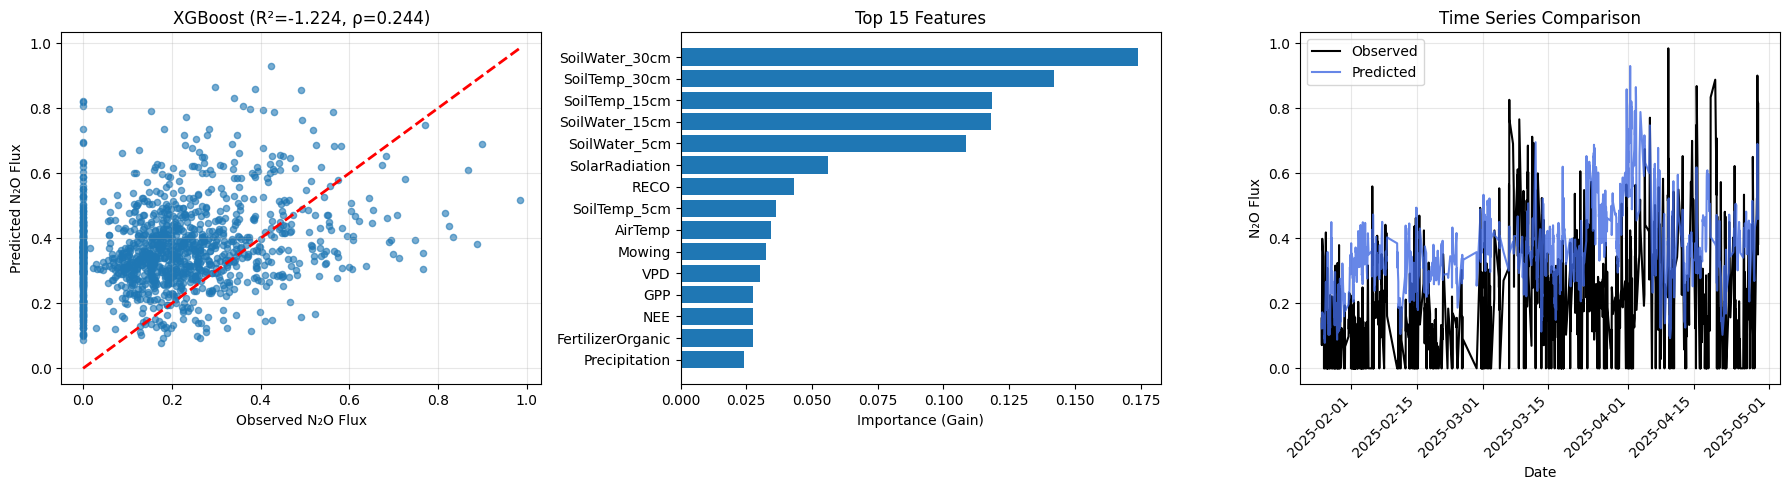


--- HOURLY | target=N2O_Flux_ln | predictors=LAG ---
Train period: 2024-03-07 21:15:00 → 2025-01-08 04:15:00
Test  period: 2025-01-08 05:15:00 → 2025-05-03 13:15:00

Model evaluation:
  R² (linear scale): -0.612
  Spearman ρ:        0.268


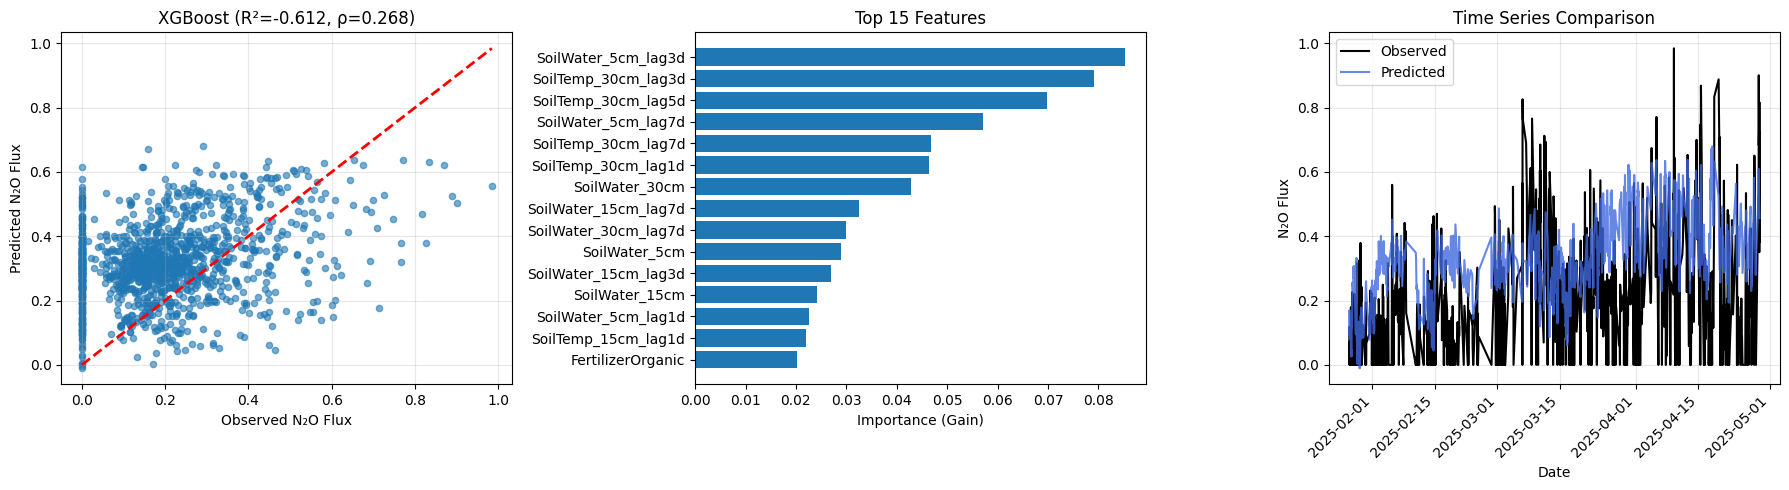


--- DAILY | target=N2O_Flux_ln | predictors=BASE ---
Train period: 0 → 320
Test  period: 321 → 413

Model evaluation:
  R² (linear scale): -0.584
  Spearman ρ:        0.470


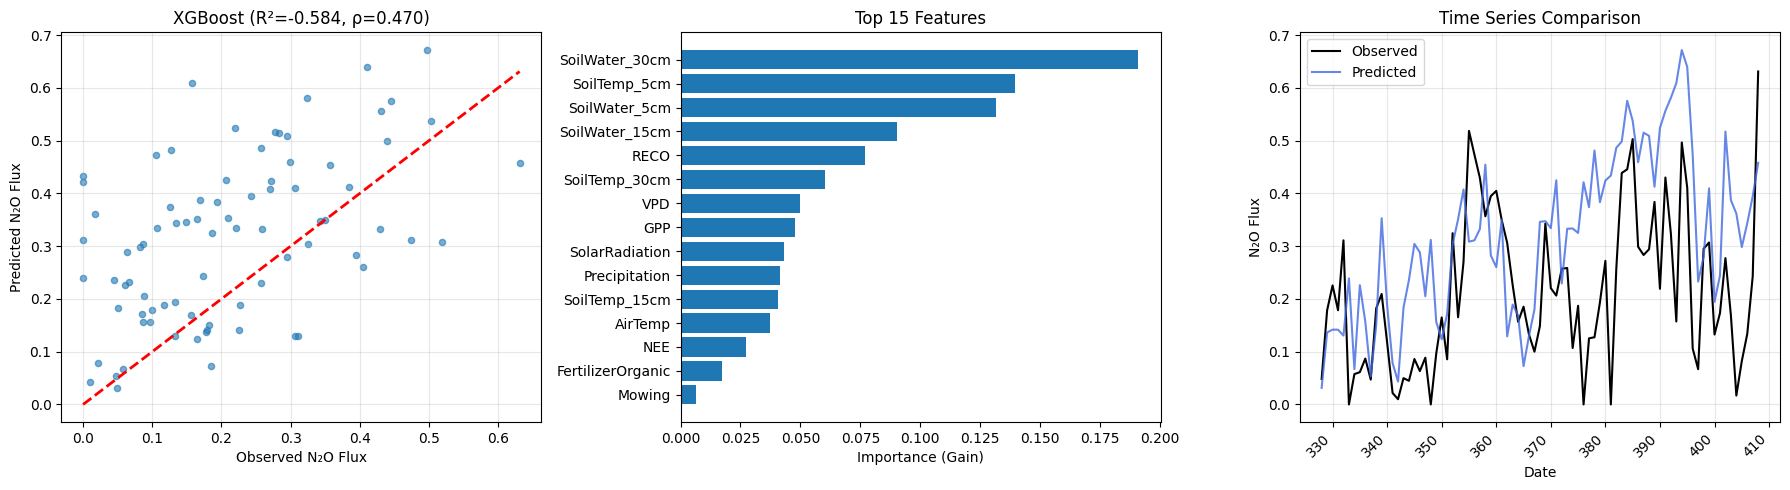


--- DAILY | target=N2O_Flux_ln | predictors=LAG ---
Train period: 0 → 297
Test  period: 298 → 413

Model evaluation:
  R² (linear scale): -0.036
  Spearman ρ:        0.348


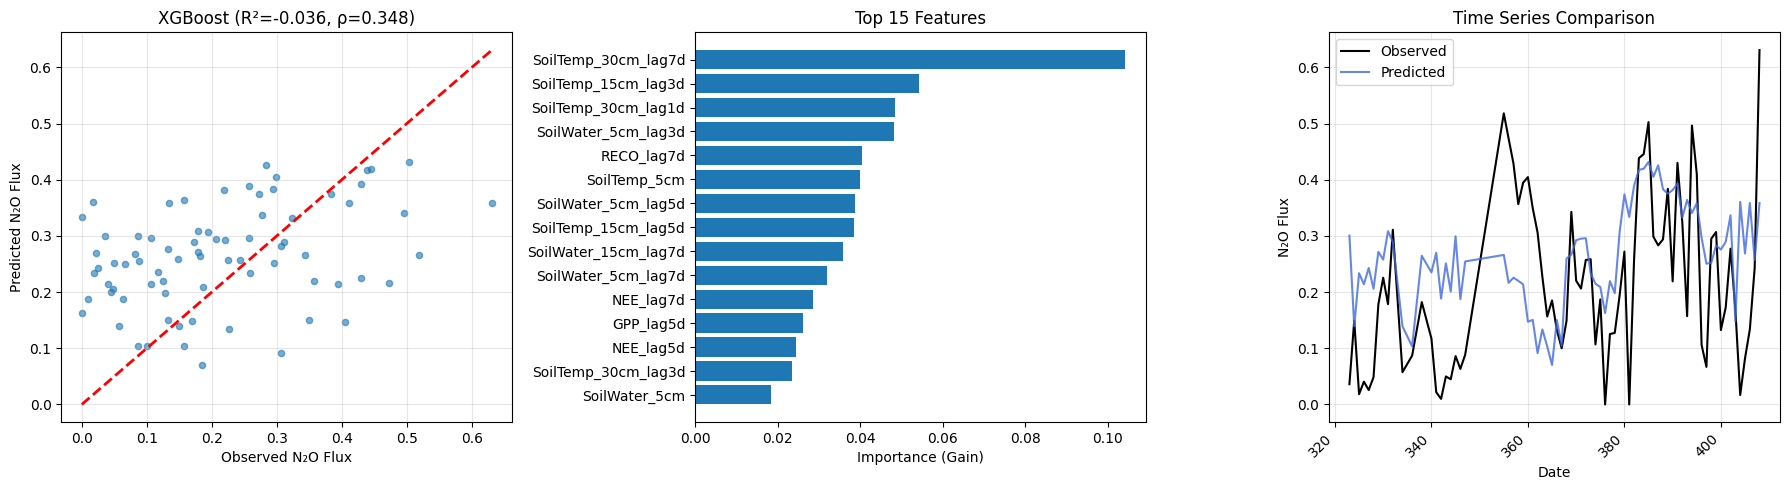


COMPREHENSIVE COMPARISON OF ALL EXPERIMENTS:
Temporal     Predictors   R²       Spearman ρ  
--------------------------------------------------------------------------------
Hourly       Base         -1.224        0.244
Hourly       Lag          -0.612        0.268
Daily        Base         -0.584        0.470
Daily        Lag          -0.036        0.348

IMPROVEMENT FROM BASE TO LAG:
Hourly: R² + 0.613, ρ + 0.023
Daily:  R² + 0.548, ρ +-0.122


In [177]:
# ============================================================================
# FOREL
# ============================================================================

print("="*80)
print("EXPERIMENT 5: Forel 2024-25")
print("="*80)

# Define base and lag predictors
base_predictors = [
    "Precipitation", "SolarRadiation", "AirTemp", "VPD",
    "SoilWater_5cm", "SoilWater_15cm", "SoilWater_30cm",
    "SoilTemp_5cm", "SoilTemp_15cm", "SoilTemp_30cm",
    "NEE", "GPP", "RECO",
    "Mowing", "FertilizerOrganic", "FertilizerMineral"
]

lag_predictors = [
    # --- Meteorological base variables ---
    "Precipitation", "SolarRadiation", "AirTemp", "VPD",
    "SoilWater_5cm", "SoilWater_15cm", "SoilWater_30cm",
    "SoilTemp_5cm", "SoilTemp_15cm", "SoilTemp_30cm",
    "NEE", "GPP", "RECO",

    # --- Meteorological lag variables ---
    "Precipitation_lag1d", "Precipitation_lag3d", "Precipitation_lag5d", "Precipitation_lag7d",
    "SolarRadiation_lag1d", "SolarRadiation_lag3d", "SolarRadiation_lag5d", "SolarRadiation_lag7d",
    "AirTemp_lag1d", "AirTemp_lag3d", "AirTemp_lag5d", "AirTemp_lag7d",
    "VPD_lag1d", "VPD_lag3d", "VPD_lag5d", "VPD_lag7d",
    "SoilWater_5cm_lag1d", "SoilWater_5cm_lag3d", "SoilWater_5cm_lag5d", "SoilWater_5cm_lag7d",
    "SoilWater_15cm_lag1d", "SoilWater_15cm_lag3d", "SoilWater_15cm_lag5d", "SoilWater_15cm_lag7d",
    "SoilWater_30cm_lag1d", "SoilWater_30cm_lag3d", "SoilWater_30cm_lag5d", "SoilWater_30cm_lag7d",
    "SoilTemp_5cm_lag1d", "SoilTemp_5cm_lag3d", "SoilTemp_5cm_lag5d", "SoilTemp_5cm_lag7d",
    "SoilTemp_15cm_lag1d", "SoilTemp_15cm_lag3d", "SoilTemp_15cm_lag5d", "SoilTemp_15cm_lag7d",
    "SoilTemp_30cm_lag1d", "SoilTemp_30cm_lag3d", "SoilTemp_30cm_lag5d", "SoilTemp_30cm_lag7d",
    "NEE_lag1d", "NEE_lag3d", "NEE_lag5d", "NEE_lag7d",
    "GPP_lag1d", "GPP_lag3d", "GPP_lag5d", "GPP_lag7d",
    "RECO_lag1d", "RECO_lag3d", "RECO_lag5d", "RECO_lag7d",

    # --- Management variables ---
    "Mowing", "FertilizerOrganic", "FertilizerMineral",
    "DaysSince_Mowing", "DaysSince_FertilizerOrganic", "DaysSince_FertilizerMineral"
]

# Store results for comparison
all_results = []

# ============================================================================
# HOURLY DATA - BASE PREDICTORS
# ============================================================================
print("\n" + "="*80)
print("--- HOURLY | target=N2O_Flux_ln | predictors=BASE ---")
print("="*80)

results_hourly_base = train_xgb_timeseries(
    df=forel_lag,
    predictors=base_predictors,
    target="N2O_Flux_ln",
    plot=True
)
all_results.append(("Hourly", "Base", results_hourly_base['r2'], results_hourly_base['spearman_rho']))

# ============================================================================
# HOURLY DATA - LAG PREDICTORS
# ============================================================================
print("\n" + "="*80)
print("--- HOURLY | target=N2O_Flux_ln | predictors=LAG ---")
print("="*80)

results_hourly_lag = train_xgb_timeseries(
    df=forel_lag,
    predictors=lag_predictors,
    target="N2O_Flux_ln",
    plot=True
)
all_results.append(("Hourly", "Lag", results_hourly_lag['r2'], results_hourly_lag['spearman_rho']))

# ============================================================================
# DAILY DATA - BASE PREDICTORS
# ============================================================================
print("\n" + "="*80)
print("--- DAILY | target=N2O_Flux_ln | predictors=BASE ---")
print("="*80)

results_daily_base = train_xgb_timeseries(
    df=forel_daily,
    predictors=base_predictors,
    target="N2O_Flux_ln",
    plot=True
)
all_results.append(("Daily", "Base", results_daily_base['r2'], results_daily_base['spearman_rho']))

# ============================================================================
# DAILY DATA - LAG PREDICTORS
# ============================================================================
print("\n" + "="*80)
print("--- DAILY | target=N2O_Flux_ln | predictors=LAG ---")
print("="*80)

results_daily_lag = train_xgb_timeseries(
    df=forel_daily,
    predictors=lag_predictors,
    target="N2O_Flux_ln",
    plot=True
)
all_results.append(("Daily", "Lag", results_daily_lag['r2'], results_daily_lag['spearman_rho']))

# ============================================================================
# COMPREHENSIVE COMPARISON
# ============================================================================
print("\n" + "="*80)
print("COMPREHENSIVE COMPARISON OF ALL EXPERIMENTS:")
print("="*80)
print(f"{'Temporal':<12} {'Predictors':<12} {'R²':<8} {'Spearman ρ':<12}")
print("-"*80)
for temp, pred, r2, rho in all_results:
    print(f"{temp:<12} {pred:<12} {r2:>6.3f}   {rho:>10.3f}")

print("\n" + "="*80)
print("IMPROVEMENT FROM BASE TO LAG:")
print("="*80)
print(f"Hourly: R² +{(results_hourly_lag['r2'] - results_hourly_base['r2']):>6.3f}, ρ +{(results_hourly_lag['spearman_rho'] - results_hourly_base['spearman_rho']):>6.3f}")
print(f"Daily:  R² +{(results_daily_lag['r2'] - results_daily_base['r2']):>6.3f}, ρ +{(results_daily_lag['spearman_rho'] - results_daily_base['spearman_rho']):>6.3f}")

# Experiment 6: Tanikon

In [178]:
# FIX TIMESTAMP
tanikon_lag['Timestamp'] = pd.to_datetime(tanikon_lag['Timestamp'])
tanikon_lag = tanikon_lag.set_index('Timestamp').sort_index()

tanikon_daily['Date'] = pd.to_datetime(tanikon_daily['Date'])
tanikon_daily = tanikon_daily.sort_values('Date')

# SPLIT BY PARCEL
tanikon_A = tanikon_lag[tanikon_lag['Parcel'] == 'A'].copy()
tanikon_B = tanikon_lag[tanikon_lag['Parcel'] == 'B'].copy()
tanikon_daily_A = tanikon_daily[tanikon_daily['Parcel'] == 'A'].set_index('Date')
tanikon_daily_B = tanikon_daily[tanikon_daily['Parcel'] == 'B'].set_index('Date')

# PREDICTOR SETS
predictor_sets = {
    "base": [
        "Precipitation", "SolarRadiation", "AirTemp", "VPD",
        "SoilWater_5cm", "SoilWater_15cm", "SoilWater_30cm", "SoilTemp_5cm", "SoilTemp_15cm", "SoilTemp_30cm",
        "NEE", "GPP", "RECO",
        "Mowing", "FertilizerOrganic", "FertilizerMineral", "SoilCultivation"
    ],
    
    "lag": [
        "Precipitation", "SolarRadiation", "AirTemp", "VPD",
        "SoilWater_5cm", "SoilWater_15cm", "SoilWater_30cm", "SoilTemp_5cm", "SoilTemp_15cm", "SoilTemp_30cm",
        "NEE", "GPP", "RECO",
        "Precipitation_lag1d", "Precipitation_lag3d", "Precipitation_lag5d", "Precipitation_lag7d",
        "SolarRadiation_lag1d", "SolarRadiation_lag3d", "SolarRadiation_lag5d", "SolarRadiation_lag7d",
        "AirTemp_lag1d", "AirTemp_lag3d", "AirTemp_lag5d", "AirTemp_lag7d",
        "VPD_lag1d", "VPD_lag3d", "VPD_lag5d", "VPD_lag7d",
        "SoilWater_5cm_lag1d", "SoilWater_5cm_lag3d", "SoilWater_5cm_lag5d", "SoilWater_5cm_lag7d",
        "SoilWater_15cm_lag1d", "SoilWater_15cm_lag3d", "SoilWater_15cm_lag5d", "SoilWater_15cm_lag7d",
        'SoilWater_30cm_lag1d', 'SoilWater_30cm_lag3d', 'SoilWater_30cm_lag5d', 'SoilWater_30cm_lag7d',
        "SoilTemp_5cm_lag1d", "SoilTemp_5cm_lag3d", "SoilTemp_5cm_lag5d", "SoilTemp_5cm_lag7d",
        "SoilTemp_15cm_lag1d", "SoilTemp_15cm_lag3d", "SoilTemp_15cm_lag5d", "SoilTemp_15cm_lag7d",
        'SoilTemp_30cm_lag1d', 'SoilTemp_30cm_lag3d', 'SoilTemp_30cm_lag5d', 'SoilTemp_30cm_lag7d',
        "NEE_lag1d", "NEE_lag3d", "NEE_lag5d", "NEE_lag7d",
        "GPP_lag1d", "GPP_lag3d", "GPP_lag5d", "GPP_lag7d",
        "RECO_lag1d", "RECO_lag3d", "RECO_lag5d", "RECO_lag7d",
        "Mowing", "FertilizerOrganic", "FertilizerMineral", "SoilCultivation",
        "DaysSince_Mowing", "DaysSince_FertilizerOrganic", "DaysSince_FertilizerMineral", "DaysSince_SoilCultivation"
    ],
    
    "main": ["AirTemp", "VPD", "SoilTemp_5cm", "SoilTemp_15cm", "RECO", "SolarRadiation"]
}

# DATASETS
datasets = {
    "Hourly": tanikon_lag,
    "Hourly A": tanikon_A,
    "Hourly B": tanikon_B,
    "Daily A": tanikon_daily_A,
    "Daily B": tanikon_daily_B,
    "Daily": tanikon_daily
}

targets = ["N2O_Flux", "N2O_Flux_ln"]

In [179]:
# RUN ALL EXPERIMENTS
results = []

for df_name, df in datasets.items():
    for target in targets:
        for set_name, preds in predictor_sets.items():
            print(f"\n{df_name} | {target} | {set_name}")
            
            try:
                # PREP DATA
                X = df[preds]
                y = df[target]
                mask = X.notna().all(axis=1) & y.notna()
                X, y = X[mask], y[mask]
                
                # OFFSET
                offset = abs(y.min()) + 1e-6
                y = y + offset
                
                # SPLIT
                split = int(len(X) * 0.9)
                X_train, X_test = X.iloc[:split], X.iloc[split:]
                y_train, y_test = y.iloc[:split], y.iloc[split:]
                
                # TRAIN
                model = XGBRegressor(
                    max_depth=6,
                    learning_rate=0.1,
                    n_estimators=300,
                    subsample=0.8,
                    colsample_bytree=0.8,
                    random_state=42,
                    n_jobs=-1
                )
                model.fit(X_train, y_train, verbose=False)
                
                # PREDICT
                y_pred = model.predict(X_test) - offset
                y_test = y_test - offset
                
                # EVALUATE
                r2 = r2_score(y_test, y_pred)
                rho, _ = spearmanr(y_test, y_pred)
                
                results.append({
                    "Dataset": df_name,
                    "Target": target,
                    "Predictors": set_name,
                    "R2": r2,
                    "Spearman": rho
                })
                
                print(f"  R²={r2:.3f}, ρ={rho:.3f}")
                
            except Exception as e:
                print(f"  ERROR: {e}")
                results.append({
                    "Dataset": df_name,
                    "Target": target,
                    "Predictors": set_name,
                    "R2": None,
                    "Spearman": None
                })

# DISPLAY RESULTS
results_df = pd.DataFrame(results)
print("\n" + "="*60)
print("=== Summary Results ===")
print(results_df.round(3))


Hourly | N2O_Flux | base
  R²=-8.121, ρ=0.146

Hourly | N2O_Flux | lag
  R²=-5.874, ρ=0.519

Hourly | N2O_Flux | main
  R²=-28.598, ρ=0.051

Hourly | N2O_Flux_ln | base
  R²=-65.989, ρ=0.054

Hourly | N2O_Flux_ln | lag
  R²=-24.829, ρ=0.286

Hourly | N2O_Flux_ln | main
  R²=-20.471, ρ=-0.070

Hourly A | N2O_Flux | base
  R²=-1.616, ρ=0.446

Hourly A | N2O_Flux | lag
  R²=-1.705, ρ=0.639

Hourly A | N2O_Flux | main
  R²=-33.376, ρ=0.498

Hourly A | N2O_Flux_ln | base
  R²=-11.689, ρ=-0.053

Hourly A | N2O_Flux_ln | lag
  R²=-10.939, ρ=0.311

Hourly A | N2O_Flux_ln | main
  R²=-22.192, ρ=-0.116

Hourly B | N2O_Flux | base
  R²=-8.872, ρ=0.007

Hourly B | N2O_Flux | lag
  R²=-8.800, ρ=0.093

Hourly B | N2O_Flux | main
  R²=-7.882, ρ=0.085

Hourly B | N2O_Flux_ln | base
  R²=-21.795, ρ=0.123

Hourly B | N2O_Flux_ln | lag
  R²=-24.173, ρ=0.284

Hourly B | N2O_Flux_ln | main
  R²=-3.923, ρ=0.011

Daily A | N2O_Flux | base
  R²=-13.345, ρ=0.511

Daily A | N2O_Flux | lag
  R²=-31.817, ρ=0.465

In [180]:
def train_xgb_timeseries(df, predictors, target, test_size=0.1, n_estimators=300, random_state=42, plot=True):
    """
    Train XGBoost on time-series data using chronological split.
    
    Now includes a time series comparison plot showing observed vs predicted values over time.
    """
    # ENSURE TIME ORDER
    df = df.sort_index().copy()
    
    # EXTRACT FEATURES/TARGET
    X = df[predictors]
    y = df[target]
    
    # HANDLE NaNs
    mask = X.notna().all(axis=1) & y.notna()
    X, y = X[mask], y[mask]
    
    # OFFSET FOR POSITIVITY
    offset = abs(y.min()) + 1e-6
    y_shifted = y + offset
    
    # CHRONOLOGICAL SPLIT
    split_idx = int(len(X) * (1 - test_size))
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y_shifted.iloc[:split_idx], y_shifted.iloc[split_idx:]
    
    # Store test dates for time series plot
    test_dates = X_test.index
    
    time_train = (df.index.min(), df.index[:split_idx].max())
    time_test = (df.index[split_idx], df.index.max())
    
    print(f"Train period: {time_train[0]} → {time_train[1]}")
    print(f"Test  period: {time_test[0]} → {time_test[1]}")
    
    # TRAIN MODEL
    model = XGBRegressor(
        n_estimators=n_estimators,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=random_state,
        n_jobs=-1
    )
    model.fit(X_train, y_train, verbose=False)
    
    # PREDICTIONS
    y_pred = model.predict(X_test)
    
    # REVERT OFFSET
    y_pred_lin = y_pred - offset
    y_test_lin = y_test - offset
    
    # EVALUATION
    r2 = r2_score(y_test_lin, y_pred_lin)
    rho, _ = spearmanr(y_test_lin, y_pred_lin)
    
    # FEATURE IMPORTANCE
    importances = pd.Series(model.feature_importances_, index=predictors).sort_values(ascending=False)
    
    print("\nModel evaluation:")
    print(f"  R² (linear scale): {r2:.3f}")
    print(f"  Spearman ρ:        {rho:.3f}")
    
    # PLOT
    if plot:
        # Create 3-subplot figure: scatter, feature importance, and TIME SERIES
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))
        
        # 1. Scatter plot
        axes[0].scatter(y_test_lin, y_pred_lin, alpha=0.6, s=20)
        min_val, max_val = y_test_lin.min(), y_test_lin.max()
        axes[0].plot([min_val, max_val], [min_val, max_val], "r--", lw=2)
        axes[0].set_xlabel("Observed N₂O Flux")
        axes[0].set_ylabel("Predicted N₂O Flux")
        axes[0].set_title(f"XGBoost (R²={r2:.3f}, ρ={rho:.3f})")
        axes[0].grid(True, alpha=0.3)
        
        # 2. Feature importance
        top_features = importances.head(15)
        axes[1].barh(range(len(top_features)), top_features.values)
        axes[1].set_yticks(range(len(top_features)))
        axes[1].set_yticklabels(top_features.index)
        axes[1].set_xlabel("Importance (Gain)")
        axes[1].set_title("Top 15 Features")
        axes[1].invert_yaxis()
        
        # 3. TIME SERIES COMPARISON (NEW!)
        axes[2].plot(test_dates, y_test_lin.values, label="Observed", color="black", lw=1.5)
        axes[2].plot(test_dates, y_pred_lin, label="Predicted", color="royalblue", lw=1.5, alpha=0.8)
        axes[2].set_xlabel("Date")
        axes[2].set_ylabel("N₂O Flux")
        axes[2].set_title("Time Series Comparison")
        axes[2].legend()
        axes[2].grid(True, alpha=0.3)
        
        # Rotate x-axis labels for better readability
        plt.setp(axes[2].xaxis.get_majorticklabels(), rotation=45, ha='right')
        
        plt.tight_layout()
        plt.show()
    
    return {
        "model": model,
        "r2": r2,
        "spearman_rho": rho,
        "feature_importance": importances,
        "y_test": y_test_lin,
        "y_pred": y_pred_lin,
        "test_dates": test_dates,  # Also return test dates
    }

EXPERIMENT 6: Tanikon 2023-25

--- HOURLY | target=N2O_Flux_ln | predictors=BASE ---
Train period: 2023-11-07 15:45:00 → 2025-02-17 03:45:00
Test  period: 2025-02-17 04:15:00 → 2025-06-05 00:45:00

Model evaluation:
  R² (linear scale): -65.989
  Spearman ρ:        0.054


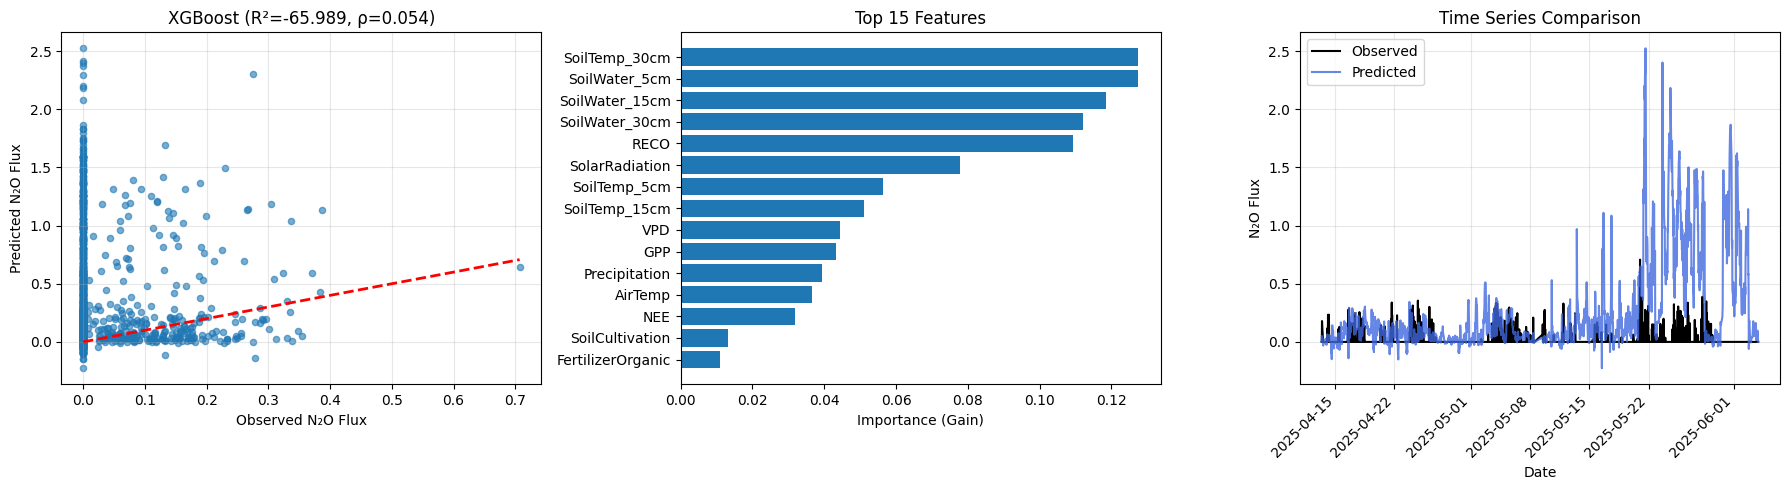


--- HOURLY | target=N2O_Flux_ln | predictors=LAG ---
Train period: 2023-11-07 15:45:00 → 2024-06-15 18:15:00
Test  period: 2024-06-15 18:45:00 → 2025-06-05 00:45:00

Model evaluation:
  R² (linear scale): -24.829
  Spearman ρ:        0.286


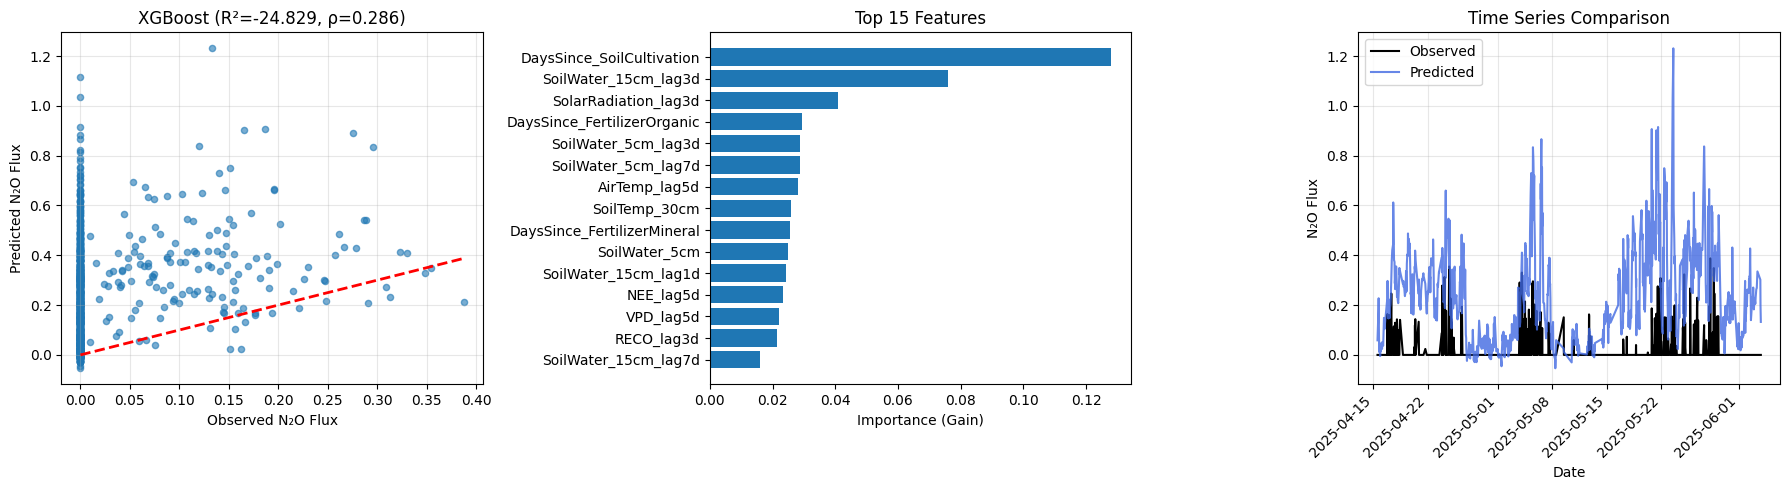


--- DAILY | target=N2O_Flux_ln | predictors=BASE ---
Train period: 0 → 717
Test  period: 718 → 877

Model evaluation:
  R² (linear scale): -3.127
  Spearman ρ:        0.147


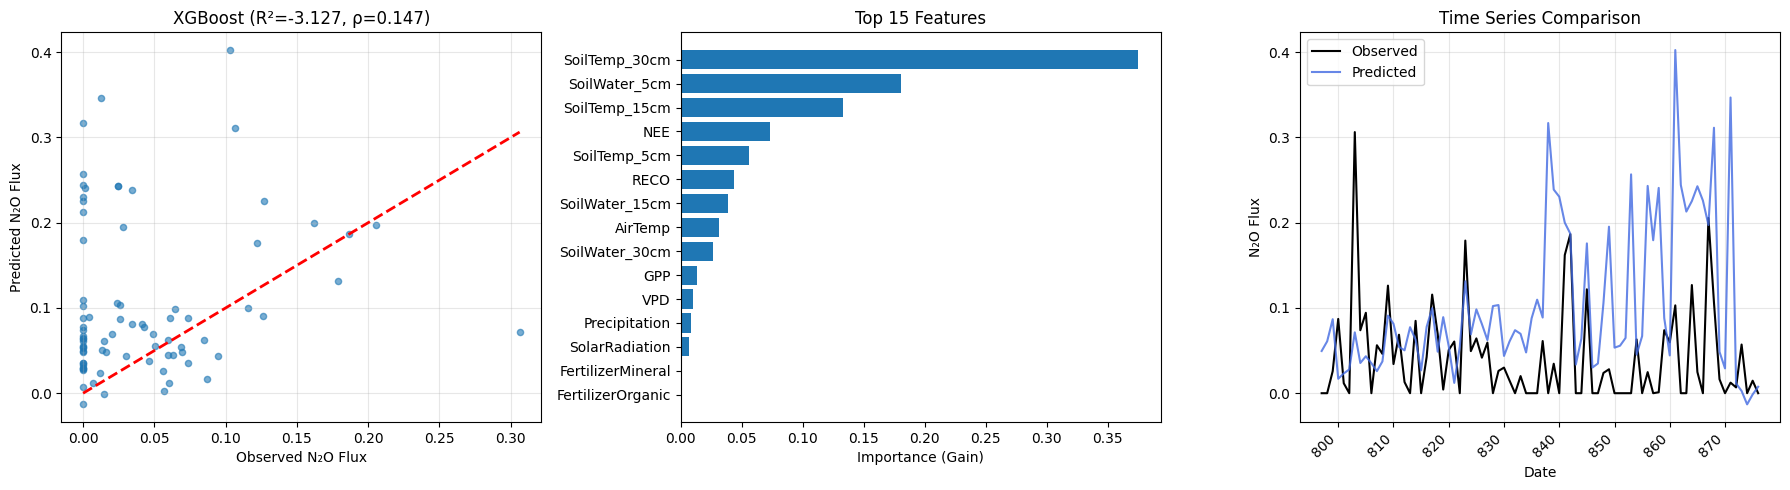


--- DAILY | target=N2O_Flux_ln | predictors=LAG ---
Train period: 0 → 575
Test  period: 576 → 877

Model evaluation:
  R² (linear scale): -4.543
  Spearman ρ:        -0.115


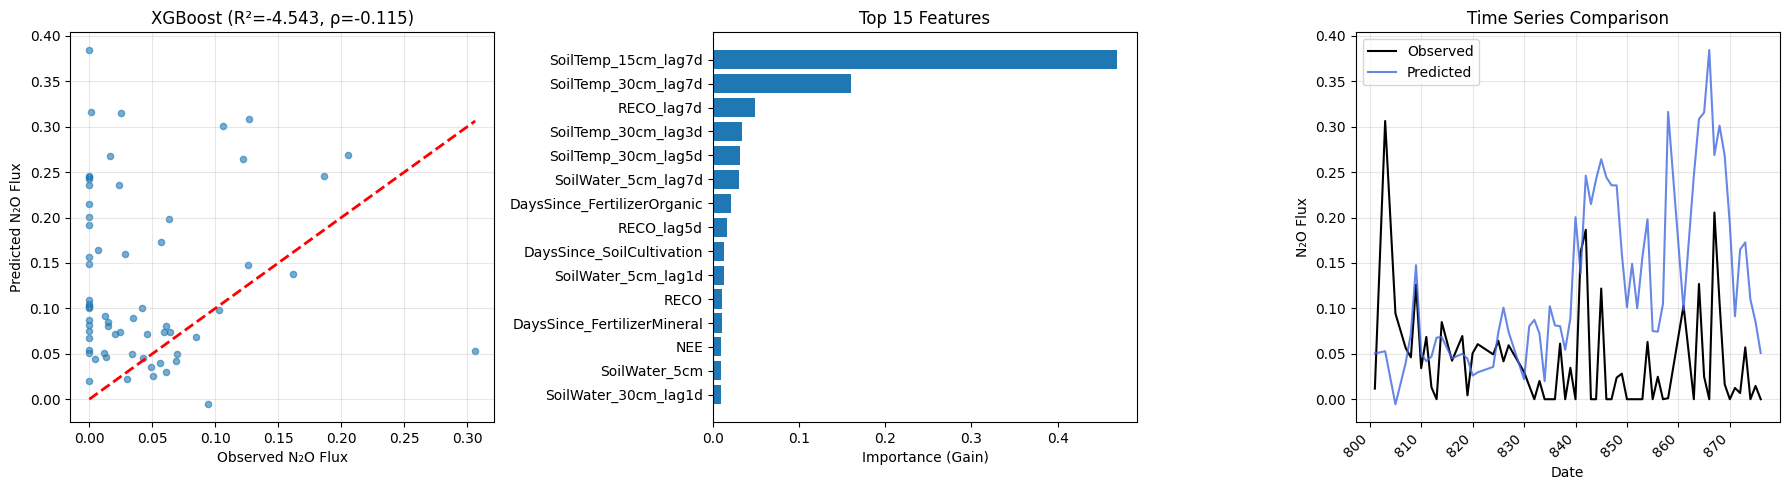


COMPREHENSIVE COMPARISON OF ALL EXPERIMENTS:
Temporal     Predictors   R²       Spearman ρ  
--------------------------------------------------------------------------------
Hourly       Base         -65.989        0.054
Hourly       Lag          -24.829        0.286
Daily        Base         -3.127        0.147
Daily        Lag          -4.543       -0.115

IMPROVEMENT FROM BASE TO LAG:
Hourly: R² +41.160, ρ + 0.231
Daily:  R² +-1.415, ρ +-0.262


In [181]:
# ============================================================================
# TANIKON
# ============================================================================

print("="*80)
print("EXPERIMENT 6: Tanikon 2023-25")
print("="*80)

# Define base and lag predictors
base_predictors = [
    "Precipitation", "SolarRadiation", "AirTemp", "VPD",
    "SoilWater_5cm", "SoilWater_15cm", "SoilWater_30cm",
    "SoilTemp_5cm", "SoilTemp_15cm", "SoilTemp_30cm",
    "NEE", "GPP", "RECO",
    "Mowing", "FertilizerOrganic", "FertilizerMineral", "SoilCultivation"
]

lag_predictors = [
    # --- Meteorological base variables ---
    "Precipitation", "SolarRadiation", "AirTemp", "VPD",
    "SoilWater_5cm", "SoilWater_15cm", "SoilWater_30cm",
    "SoilTemp_5cm", "SoilTemp_15cm", "SoilTemp_30cm",
    "NEE", "GPP", "RECO",

    # --- Meteorological lag variables ---
    "Precipitation_lag1d", "Precipitation_lag3d", "Precipitation_lag5d", "Precipitation_lag7d",
    "SolarRadiation_lag1d", "SolarRadiation_lag3d", "SolarRadiation_lag5d", "SolarRadiation_lag7d",
    "AirTemp_lag1d", "AirTemp_lag3d", "AirTemp_lag5d", "AirTemp_lag7d",
    "VPD_lag1d", "VPD_lag3d", "VPD_lag5d", "VPD_lag7d",
    "SoilWater_5cm_lag1d", "SoilWater_5cm_lag3d", "SoilWater_5cm_lag5d", "SoilWater_5cm_lag7d",
    "SoilWater_15cm_lag1d", "SoilWater_15cm_lag3d", "SoilWater_15cm_lag5d", "SoilWater_15cm_lag7d",
    "SoilWater_30cm_lag1d", "SoilWater_30cm_lag3d", "SoilWater_30cm_lag5d", "SoilWater_30cm_lag7d",
    "SoilTemp_5cm_lag1d", "SoilTemp_5cm_lag3d", "SoilTemp_5cm_lag5d", "SoilTemp_5cm_lag7d",
    "SoilTemp_15cm_lag1d", "SoilTemp_15cm_lag3d", "SoilTemp_15cm_lag5d", "SoilTemp_15cm_lag7d",
    "SoilTemp_30cm_lag1d", "SoilTemp_30cm_lag3d", "SoilTemp_30cm_lag5d", "SoilTemp_30cm_lag7d",
    "NEE_lag1d", "NEE_lag3d", "NEE_lag5d", "NEE_lag7d",
    "GPP_lag1d", "GPP_lag3d", "GPP_lag5d", "GPP_lag7d",
    "RECO_lag1d", "RECO_lag3d", "RECO_lag5d", "RECO_lag7d",

    # --- Management variables ---
    "Mowing", "FertilizerOrganic", "FertilizerMineral", "SoilCultivation",
    "DaysSince_Mowing", "DaysSince_FertilizerOrganic", "DaysSince_FertilizerMineral",
    "DaysSince_SoilCultivation"
]

# Store results for comparison
all_results = []

# ============================================================================
# HOURLY DATA - BASE PREDICTORS
# ============================================================================
print("\n" + "="*80)
print("--- HOURLY | target=N2O_Flux_ln | predictors=BASE ---")
print("="*80)

results_hourly_base = train_xgb_timeseries(
    df=tanikon_lag,
    predictors=base_predictors,
    target="N2O_Flux_ln",
    plot=True
)
all_results.append(("Hourly", "Base", results_hourly_base['r2'], results_hourly_base['spearman_rho']))

# ============================================================================
# HOURLY DATA - LAG PREDICTORS
# ============================================================================
print("\n" + "="*80)
print("--- HOURLY | target=N2O_Flux_ln | predictors=LAG ---")
print("="*80)

results_hourly_lag = train_xgb_timeseries(
    df=tanikon_lag,
    predictors=lag_predictors,
    target="N2O_Flux_ln",
    plot=True
)
all_results.append(("Hourly", "Lag", results_hourly_lag['r2'], results_hourly_lag['spearman_rho']))

# ============================================================================
# DAILY DATA - BASE PREDICTORS
# ============================================================================
print("\n" + "="*80)
print("--- DAILY | target=N2O_Flux_ln | predictors=BASE ---")
print("="*80)

results_daily_base = train_xgb_timeseries(
    df=tanikon_daily,
    predictors=base_predictors,
    target="N2O_Flux_ln",
    plot=True
)
all_results.append(("Daily", "Base", results_daily_base['r2'], results_daily_base['spearman_rho']))

# ============================================================================
# DAILY DATA - LAG PREDICTORS
# ============================================================================
print("\n" + "="*80)
print("--- DAILY | target=N2O_Flux_ln | predictors=LAG ---")
print("="*80)

results_daily_lag = train_xgb_timeseries(
    df=tanikon_daily,
    predictors=lag_predictors,
    target="N2O_Flux_ln",
    plot=True
)
all_results.append(("Daily", "Lag", results_daily_lag['r2'], results_daily_lag['spearman_rho']))

# ============================================================================
# COMPREHENSIVE COMPARISON
# ============================================================================
print("\n" + "="*80)
print("COMPREHENSIVE COMPARISON OF ALL EXPERIMENTS:")
print("="*80)
print(f"{'Temporal':<12} {'Predictors':<12} {'R²':<8} {'Spearman ρ':<12}")
print("-"*80)
for temp, pred, r2, rho in all_results:
    print(f"{temp:<12} {pred:<12} {r2:>6.3f}   {rho:>10.3f}")

print("\n" + "="*80)
print("IMPROVEMENT FROM BASE TO LAG:")
print("="*80)
print(f"Hourly: R² +{(results_hourly_lag['r2'] - results_hourly_base['r2']):>6.3f}, ρ +{(results_hourly_lag['spearman_rho'] - results_hourly_base['spearman_rho']):>6.3f}")
print(f"Daily:  R² +{(results_daily_lag['r2'] - results_daily_base['r2']):>6.3f}, ρ +{(results_daily_lag['spearman_rho'] - results_daily_base['spearman_rho']):>6.3f}")